In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV,KFold
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
import pandas as pd
from lightgbm import LGBMRegressor
import numpy as np
import gc
import os
import itertools
import sys
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import MinMaxScaler  

In [ ]:
%matplotlib inline

In [ ]:
train_path = '/content/drive/MyDrive/모듈프로젝트3_2조/train_V4.csv'

# 메모리 줄이기 함수

In [ ]:
# 메모리 줄여주는 함수
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# 파일 로드

In [ ]:
# 전처리 완료한 파일 불러오기 
# index_col = 0 은 Unnamed:0 방지 
train = pd.read_csv(train_path, index_col = 0)
# 메모리 줄이기 
train = reduce_mem_usage(train)
print(train.shape)

Memory usage of dataframe is 4.67 MB --> 1.69 MB (Decreased by 63.8%)
(20406, 29)


In [ ]:
all_data  = train.copy()
all_data1 = train.copy()

# 이상치 제거 스플릿

In [ ]:
# 기본
X = train.drop(['winPlacePerc','matchId','groupId','Id'],axis = 1)
y = train['winPlacePerc']
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# v1 - 컬럼추가

## 간단한 칼럼 추가 및 필요없는 행렬 지우기

In [ ]:
# 매치별로 그룹화해서 match라는 변수로 만듦
match = all_data.groupby('matchId')

# 비율스텟을 만들어준다 
# 킬수가 높을수록 1에 가까운 것이다.
all_data['killsPerc'] = match['kills'].rank(pct=True).values
all_data['killPlacePerc'] = match['killPlace'].rank(pct=True).values
all_data['walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
all_data['walkPerc_killsPerc'] = all_data['walkDistancePerc'] / all_data['killsPerc']

https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.rank.html

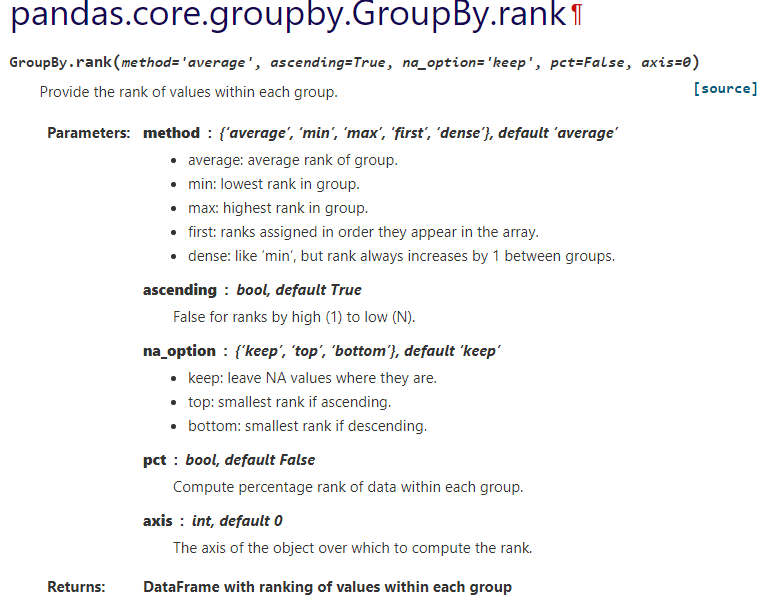

In [ ]:
all_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc
105,bd5bdcd00500db,75db831b185e63,992995bd23ab4a,0,0,36.009998,0,0,0,74,1108,0,0,0.000000,1300,duo,49,49,-1,0,0.0000,0,0.00,0,0,206.300003,2,1498,0.2500,0.291667,0.770833,0.354167,1.214286
115,b6f4250b1dd47a,ef595c5f198782,59ff1f04f1fdbf,0,5,216.699997,0,0,0,26,1507,1,1,114.900002,1436,duo,50,50,-1,1,0.0071,0,26.49,0,0,4062.000000,3,1664,0.9592,0.665000,0.260000,1.000000,1.503759
178,b4bc5f3014be9f,23cede6fc65828,a3a80601eaab75,1,2,722.400024,0,1,0,2,1320,5,1,97.430000,1296,solo,97,97,-1,0,0.0000,0,0.00,0,0,625.599976,4,1467,0.6875,0.994845,0.020619,0.628866,0.632124
180,7ee25ffd0ca4e2,4fe5f6f93af187,875e1bf0894e85,0,0,43.000000,0,0,0,41,0,1,1,12.360000,1415,solo,97,96,1491,0,0.0000,0,0.00,0,0,114.300003,2,0,0.3125,0.654639,0.422680,0.360825,0.551181
181,2332628a0a8825,4f79fff7954219,5ae9e22a50dd8e,0,0,162.100006,2,0,0,35,0,1,1,9.456000,1430,duo,48,48,1441,0,0.0000,0,0.00,0,0,118.300003,1,0,0.3191,0.682292,0.364583,0.322917,0.473282


In [ ]:
# 전체 이동거리 
all_data['_totalDistance'] = all_data['rideDistance'] + all_data['walkDistance'] + all_data['swimDistance']

In [ ]:
# 힐템 전체 사용량
all_data['_healthItems'] = all_data['heals'] + all_data['boosts']
# 헤드샷 킬의 비율
all_data['_headshotKillRate'] = all_data['headshotKills'] / all_data['kills']
# 킬순위 / 매치인원 수 즉 킬순위의 상대적 위치 비교하는 칼럼 
all_data['_killPlaceOverMaxPlace'] = all_data['killPlace'] / all_data['maxPlace']
# 걸어다닌 거리당 킬 수
all_data['_killsOverWalkDistance'] = all_data['kills'] / all_data['walkDistance']

In [ ]:
# 비율 스탯을 계산하다 생길 수 있는 Inf를 val값으로 채우는 함수 생성
def fillInf(df, val):
    numcols = df.select_dtypes(include='number').columns
    cols = numcols[numcols != 'winPlacePerc']
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    for c in cols: df[c].fillna(val, inplace=True)

In [ ]:
# 무한대가 나온 항목을 0으로 채운다 
fillInf(all_data, 0)

In [ ]:
# 필요없다고 생각하는 특징 지우기 
all_data.drop(['boosts','heals','killStreaks','DBNOs'], axis=1, inplace=True)
all_data.drop(['headshotKills','roadKills','vehicleDestroys'], axis=1, inplace=True)
all_data.drop(['rideDistance','swimDistance','matchDuration'], axis=1, inplace=True)
all_data.drop(['rankPoints','killPoints','winPoints'], axis=1, inplace=True)

## 그룹화

*   그룹은 해당 매치에서 한 팀으로 활동하는 단위이다. 같은 성적(winplaceperc)을 받는다
*   각 매치 항목 내 그룹의 위치 순서를 예측
*   유저 레벨이 아닌 그룹 레벨에서 트레이닝 시킨다.



In [ ]:
# 필요한 단위별로 묶어서 변수에 넣어둔다.
match = all_data.groupby(['matchId'])
group = all_data.groupby(['matchId','groupId','matchType'])

In [ ]:
# 필요한 칼럼이름만 남겨서 변수에 리스트화 해 둔다.
agg_col = list(all_data.columns)
exclude_agg_col = ['Id','matchId','groupId','matchType','maxPlace','numGroups','winPlacePerc']
for c in exclude_agg_col:
    agg_col.remove(c)
print(agg_col)

['assists', 'damageDealt', 'killPlace', 'kills', 'longestKill', 'revives', 'teamKills', 'walkDistance', 'weaponsAcquired', 'killsPerc', 'killPlacePerc', 'walkDistancePerc', 'walkPerc_killsPerc', '_totalDistance', '_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance']


In [ ]:
# 주요(합을 시행할 )칼럼을 변수에 넣어둔다.
sum_col = ['kills','killPlace','damageDealt','walkDistance','_healthItems']

In [ ]:
# 매치에 참여한 사람 
match.size()

matchId
02eef9566e9516    95
0442b95b39d5af    86
0678976b84277f    94
084c08d1425673    99
0974b09d4dd7c5    94
                  ..
fa64e9ecb57501    96
fda8338f429cea    96
ffb3e1f05ba75e    90
ffb7b812404f00    88
ffd04e435d243b    90
Length: 221, dtype: int64

In [ ]:
# 특정 칼럼들의 합을 수행한다.
match[sum_col].sum().head(3).rename(columns=lambda s: 'm.sum.' + s)

,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems
matchId,,,,,
02eef9566e9516,91.0,4560.0,11446.787109,84760.601562,200.0
0442b95b39d5af,83.0,3741.0,10298.219727,73793.304688,168.0
0678976b84277f,88.0,4465.0,11278.639648,79026.562500,212.0


In [ ]:
# 특정 칼럼들의 최대값을 본다. 
# rename을 통해 match.max 라는 걸 나타내준다
match[sum_col].max().head(3).rename(columns=lambda s: 'm.max.' + s)

,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._healthItems
matchId,,,,,
02eef9566e9516,8,95,750.299988,3340.0,19
0442b95b39d5af,6,86,753.599976,3760.0,19
0678976b84277f,7,94,1065.000000,4242.0,16


In [ ]:
# 특정 칼럼들의 평균값을 본다. 
match[sum_col].mean().head(3).rename(columns=lambda s: 'm.mean.' + s)

,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._healthItems
matchId,,,,,
02eef9566e9516,0.957895,48.0,120.492493,892.216858,2.105263
0442b95b39d5af,0.965116,43.5,119.746742,858.061646,1.953488
0678976b84277f,0.936170,47.5,119.985535,840.708069,2.255319


In [ ]:
# 이를 합쳐서 matchdata를 생성한다.
# 활용에 용이성을 위해 인덱스는 풀어준다.
match_data = pd.concat([
    match.size().to_frame('m.players'), 
    match[sum_col].sum().rename(columns=lambda s: 'm.sum.' + s), 
    match[sum_col].max().rename(columns=lambda s: 'm.max.' + s),
    match[sum_col].mean().rename(columns=lambda s: 'm.mean.' + s)
    ], axis=1).reset_index()

In [ ]:
# 생성 확인
match_data

,matchId,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._healthItems,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._healthItems
0,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263
1,0442b95b39d5af,86,83.0,3741.0,10298.219727,73793.304688,168.0,6,86,753.599976,3760.0,19,0.965116,43.500000,119.746742,858.061646,1.953488
2,0678976b84277f,94,88.0,4465.0,11278.639648,79026.562500,212.0,7,94,1065.000000,4242.0,16,0.936170,47.500000,119.985535,840.708069,2.255319
3,084c08d1425673,99,97.0,4950.0,12108.865234,76143.648438,194.0,9,99,802.599976,2984.0,19,0.979798,50.000000,122.311768,769.127747,1.959596
4,0974b09d4dd7c5,94,89.0,4465.0,10882.660156,73705.343750,163.0,8,94,775.000000,3544.0,15,0.946809,47.500000,115.772980,784.099365,1.734043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,fa64e9ecb57501,96,92.0,4656.0,12107.269531,89897.601562,227.0,7,96,722.099976,3312.0,15,0.958333,48.500000,126.117393,936.433411,2.364583
217,fda8338f429cea,96,89.0,4656.0,12867.201172,99925.890625,219.0,6,96,626.000000,3902.0,12,0.927083,48.500000,134.033340,1040.894653,2.281250
218,ffb3e1f05ba75e,90,82.0,4178.0,11253.780273,85249.976562,173.0,10,92,830.400024,3786.0,12,0.911111,46.422222,125.042000,947.221985,1.922222
219,ffb7b812404f00,88,86.0,3989.0,11300.209961,66925.007812,180.0,9,90,884.099976,3640.0,14,0.977273,45.329545,128.411484,760.511414,2.045455


In [ ]:
# 그룹 단위합의 데이터도 생성 
group[sum_col].sum().rename(columns=lambda s: 'g_sum.' + s)

g_sum.kills  ...  g_sum._healthItems
matchId        groupId        matchType               ...                    
02eef9566e9516 025a1c9e76fc14 solo               5.0  ...                11.0
               041749bd357d30 solo               0.0  ...                 7.0
               06eba124309c9c solo               0.0  ...                 0.0
               08ce3394a722b1 solo               3.0  ...                19.0
               0e6b9115b827b5 solo               3.0  ...                 6.0
...                                              ...  ...                 ...
ffd04e435d243b ea06fca11ff534 duo                1.0  ...                 0.0
               eba8bcd614d456 duo                2.0  ...                 4.0
               f24199a85324d8 duo                5.0  ...                 7.0
               f2e0c6db40c2da duo                1.0  ...                 0.0
               fff3be1df189d4 duo                0.0  ...                 0.0

[15798 rows x 5 columns]

In [ ]:
# 매치데이터에 추가해준다
match_data = pd.merge(match_data, 
    group[sum_col].sum().rename(columns=lambda s: 'g_sum.' + s).reset_index())

In [ ]:
# 그룹별 통계요소가 추가된 매치데이터
match_data

,matchId,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._healthItems,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._healthItems,groupId,matchType,g_sum.kills,g_sum.killPlace,g_sum.damageDealt,g_sum.walkDistance,g_sum._healthItems
0,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,025a1c9e76fc14,solo,5.0,5.0,524.000000,1996.000000,11.0
1,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,041749bd357d30,solo,0.0,99.0,0.000000,2864.000000,7.0
2,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,06eba124309c9c,solo,0.0,58.0,67.320000,447.600006,0.0
3,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,08ce3394a722b1,solo,3.0,10.0,384.000000,1702.000000,19.0
4,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,0e6b9115b827b5,solo,3.0,9.0,335.000000,2881.000000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15793,ffd04e435d243b,90,84.0,4154.0,12646.099609,93234.320312,215.0,6,91,680.599976,4559.0,16,0.933333,46.155556,140.512222,1035.936890,2.388889,ea06fca11ff534,duo,1.0,122.0,176.580002,281.799988,0.0
15794,ffd04e435d243b,90,84.0,4154.0,12646.099609,93234.320312,215.0,6,91,680.599976,4559.0,16,0.933333,46.155556,140.512222,1035.936890,2.388889,eba8bcd614d456,duo,2.0,86.0,303.010010,758.000000,4.0
15795,ffd04e435d243b,90,84.0,4154.0,12646.099609,93234.320312,215.0,6,91,680.599976,4559.0,16,0.933333,46.155556,140.512222,1035.936890,2.388889,f24199a85324d8,duo,5.0,33.0,466.799988,5317.000000,7.0
15796,ffd04e435d243b,90,84.0,4154.0,12646.099609,93234.320312,215.0,6,91,680.599976,4559.0,16,0.933333,46.155556,140.512222,1035.936890,2.388889,f2e0c6db40c2da,duo,1.0,112.0,325.730011,350.580017,0.0


In [ ]:
# 그룹별 통계
# agg_col은 위에서 만든 리스트로 
# ['assists', 'damageDealt', 'killPlace', 'kills', 'longestKill', 'revives', 'teamKills', 'walkDistance', 'weaponsAcquired', 'killsPerc', 'killPlacePerc', 'walkDistancePerc', 'walkPerc_killsPerc', '_totalDistance', '_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance']
# 이다. 너무 길당 
# 해당 그룹단위로 사람수, 평균, agg_col에 해당하는 요소의 max와 min값 
all_data = pd.concat([
    group.size().to_frame('players'),
    group.mean(),
    group[agg_col].max().rename(columns=lambda s: 'g_max.' + s),
    group[agg_col].min().rename(columns=lambda s: 'g_min.' + s),
    ], axis=1).reset_index()
# 메모리 절약
all_data = reduce_mem_usage(all_data)

print(all_data.shape)

Memory usage of dataframe is 4.91 MB --> 3.18 MB (Decreased by 35.3%)
(15798, 61)


In [ ]:
match_data

,matchId,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._healthItems,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._healthItems,groupId,matchType,g_sum.kills,g_sum.killPlace,g_sum.damageDealt,g_sum.walkDistance,g_sum._healthItems
0,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,025a1c9e76fc14,solo,5.0,5.0,524.000000,1996.000000,11.0
1,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,041749bd357d30,solo,0.0,99.0,0.000000,2864.000000,7.0
2,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,06eba124309c9c,solo,0.0,58.0,67.320000,447.600006,0.0
3,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,08ce3394a722b1,solo,3.0,10.0,384.000000,1702.000000,19.0
4,02eef9566e9516,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,0e6b9115b827b5,solo,3.0,9.0,335.000000,2881.000000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15793,ffd04e435d243b,90,84.0,4154.0,12646.099609,93234.320312,215.0,6,91,680.599976,4559.0,16,0.933333,46.155556,140.512222,1035.936890,2.388889,ea06fca11ff534,duo,1.0,122.0,176.580002,281.799988,0.0
15794,ffd04e435d243b,90,84.0,4154.0,12646.099609,93234.320312,215.0,6,91,680.599976,4559.0,16,0.933333,46.155556,140.512222,1035.936890,2.388889,eba8bcd614d456,duo,2.0,86.0,303.010010,758.000000,4.0
15795,ffd04e435d243b,90,84.0,4154.0,12646.099609,93234.320312,215.0,6,91,680.599976,4559.0,16,0.933333,46.155556,140.512222,1035.936890,2.388889,f24199a85324d8,duo,5.0,33.0,466.799988,5317.000000,7.0
15796,ffd04e435d243b,90,84.0,4154.0,12646.099609,93234.320312,215.0,6,91,680.599976,4559.0,16,0.933333,46.155556,140.512222,1035.936890,2.388889,f2e0c6db40c2da,duo,1.0,112.0,325.730011,350.580017,0.0


In [ ]:
all_data

,matchId,groupId,matchType,players,assists,damageDealt,killPlace,kills,longestKill,maxPlace,numGroups,revives,teamKills,walkDistance,weaponsAcquired,winPlacePerc,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,g_max.assists,g_max.damageDealt,g_max.killPlace,g_max.kills,g_max.longestKill,g_max.revives,g_max.teamKills,g_max.walkDistance,g_max.weaponsAcquired,g_max.killsPerc,g_max.killPlacePerc,g_max.walkDistancePerc,g_max.walkPerc_killsPerc,g_max._totalDistance,g_max._healthItems,g_max._headshotKillRate,g_max._killPlaceOverMaxPlace,g_max._killsOverWalkDistance,g_min.assists,g_min.damageDealt,g_min.killPlace,g_min.kills,g_min.longestKill,g_min.revives,g_min.teamKills,g_min.walkDistance,g_min.weaponsAcquired,g_min.killsPerc,g_min.killPlacePerc,g_min.walkDistancePerc,g_min.walkPerc_killsPerc,g_min._totalDistance,g_min._healthItems,g_min._headshotKillRate,g_min._killPlaceOverMaxPlace,g_min._killsOverWalkDistance
0,02eef9566e9516,025a1c9e76fc14,solo,1,0.0,524.000000,5.0,5.0,152.199997,95.0,94.0,0.0,0.0,1996.000000,4.0,0.8723,0.968421,0.052632,0.842105,0.869565,1996.000000,11.0,0.400000,0.052632,0.002505,0,524.000000,5,5,152.199997,0,0,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,0.400000,0.052632,0.002505,0,524.000000,5,5,152.199997,0,0,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,0.400000,0.052632,0.002505
1,02eef9566e9516,041749bd357d30,solo,2,0.0,0.000000,49.5,0.0,0.000000,95.0,94.0,0.0,0.0,1432.000000,3.0,0.7128,0.289474,0.521053,0.726316,2.509091,1432.000000,3.5,0.000000,0.521053,0.000000,0,0.000000,50,0,0.000000,0,0,1928.000000,5,0.289474,0.526316,0.831579,2.872727,1928.000000,6,0.000000,0.526316,0.000000,0,0.000000,49,0,0.000000,0,0,936.000000,1,0.289474,0.515789,0.621053,2.145455,936.000000,1,0.000000,0.515789,0.000000
2,02eef9566e9516,06eba124309c9c,solo,1,0.0,67.320000,58.0,0.0,0.000000,95.0,94.0,0.0,0.0,447.600006,3.0,0.5000,0.289474,0.610526,0.505263,1.745455,447.600006,0.0,0.000000,0.610526,0.000000,0,67.320000,58,0,0.000000,0,0,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,0.000000,0.610526,0.000000,0,67.320000,58,0,0.000000,0,0,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,0.000000,0.610526,0.000000
3,02eef9566e9516,08ce3394a722b1,solo,1,0.0,384.000000,10.0,3.0,130.600006,95.0,94.0,0.0,0.0,1702.000000,8.0,0.9468,0.894737,0.105263,0.789474,0.882353,3716.000000,19.0,0.333333,0.105263,0.001763,0,384.000000,10,3,130.600006,0,0,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,0.333333,0.105263,0.001763,0,384.000000,10,3,130.600006,0,0,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,0.333333,0.105263,0.001763
4,02eef9566e9516,0e6b9115b827b5,solo,1,0.0,335.000000,9.0,3.0,126.400002,95.0,94.0,0.0,0.0,2881.000000,5.0,0.9894,0.894737,0.094737,0.947368,1.058824,3034.300049,6.0,1.000000,0.094737,0.001041,0,335.000000,9,3,126.400002,0,0,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,1.000000,0.094737,0.001041,0,335.000000,9,3,126.400002,0,0,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,1.000000,0.094737,0.001041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15793,ffd04e435d243b,ea06fca11ff534,duo,2,0.0,88.290001,61.0,0.5,3.369000,46.0,45.0,0.0,0.0,140.899994,3.0,0.1111,0.472222,0.666667,0.250000,0.647059,140.899994,0.0,0.000000,1.326087,0.003799,0,148.500000,82,1,6.738000,0,0,150.199997,3,0.661111,0.900000,0.266667,0.941176,150.199997,0,0.000000,1.782609,0.007599,0,28.080000,40,0,0.000000,0,0,131.600006,3,0.283333,0.433333,0.233333,0.352941,131.600006,0,0.000000,0.869565,0.000000
15794,ffd04e435d243b,eba8bcd614d456,duo,2,1.0,151.505005,43.0,1.0,24.790001,46.0,45.0,0.5,0.0,379.000000,2.5,0.3556,

In [ ]:
# 힘들게 만든 매치별 데이터를 본래 데이터와 합쳐준다.
all_data = pd.merge(all_data, match_data)

# 메모리 절약용
del match_data
gc.collect()

78

In [ ]:
all_data

,matchId,groupId,matchType,players,assists,damageDealt,killPlace,kills,longestKill,maxPlace,numGroups,revives,teamKills,walkDistance,weaponsAcquired,winPlacePerc,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,g_max.assists,g_max.damageDealt,g_max.killPlace,g_max.kills,g_max.longestKill,g_max.revives,g_max.teamKills,g_max.walkDistance,g_max.weaponsAcquired,g_max.killsPerc,g_max.killPlacePerc,g_max.walkDistancePerc,g_max.walkPerc_killsPerc,g_max._totalDistance,g_max._healthItems,...,g_max._killsOverWalkDistance,g_min.assists,g_min.damageDealt,g_min.killPlace,g_min.kills,g_min.longestKill,g_min.revives,g_min.teamKills,g_min.walkDistance,g_min.weaponsAcquired,g_min.killsPerc,g_min.killPlacePerc,g_min.walkDistancePerc,g_min.walkPerc_killsPerc,g_min._totalDistance,g_min._healthItems,g_min._headshotKillRate,g_min._killPlaceOverMaxPlace,g_min._killsOverWalkDistance,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._healthItems,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._healthItems,g_sum.kills,g_sum.killPlace,g_sum.damageDealt,g_sum.walkDistance,g_sum._healthItems
0,02eef9566e9516,025a1c9e76fc14,solo,1,0.0,524.000000,5.0,5.0,152.199997,95.0,94.0,0.0,0.0,1996.000000,4.0,0.8723,0.968421,0.052632,0.842105,0.869565,1996.000000,11.0,0.400000,0.052632,0.002505,0,524.000000,5,5,152.199997,0,0,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,...,0.002505,0,524.000000,5,5,152.199997,0,0,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,0.400000,0.052632,0.002505,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,5.0,5.0,524.000000,1996.000000,11.0
1,02eef9566e9516,041749bd357d30,solo,2,0.0,0.000000,49.5,0.0,0.000000,95.0,94.0,0.0,0.0,1432.000000,3.0,0.7128,0.289474,0.521053,0.726316,2.509091,1432.000000,3.5,0.000000,0.521053,0.000000,0,0.000000,50,0,0.000000,0,0,1928.000000,5,0.289474,0.526316,0.831579,2.872727,1928.000000,6,...,0.000000,0,0.000000,49,0,0.000000,0,0,936.000000,1,0.289474,0.515789,0.621053,2.145455,936.000000,1,0.000000,0.515789,0.000000,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,0.0,99.0,0.000000,2864.000000,7.0
2,02eef9566e9516,06eba124309c9c,solo,1,0.0,67.320000,58.0,0.0,0.000000,95.0,94.0,0.0,0.0,447.600006,3.0,0.5000,0.289474,0.610526,0.505263,1.745455,447.600006,0.0,0.000000,0.610526,0.000000,0,67.320000,58,0,0.000000,0,0,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,...,0.000000,0,67.320000,58,0,0.000000,0,0,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,0.000000,0.610526,0.000000,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,0.0,58.0,67.320000,447.600006,0.0
3,02eef9566e9516,08ce3394a722b1,solo,1,0.0,384.000000,10.0,3.0,130.600006,95.0,94.0,0.0,0.0,1702.000000,8.0,0.9468,0.894737,0.105263,0.789474,0.882353,3716.000000,19.0,0.333333,0.105263,0.001763,0,384.000000,10,3,130.600006,0,0,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,...,0.001763,0,384.000000,10,3,130.600006,0,0,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,0.333333,0.105263,0.001763,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,3.0,10.0,384.000000,1702.000000,19.0
4,02eef9566e9516,0e6b9115b827b5,solo,1,0.0,335.000000,9.0,3.0,126.400002,95.0,94.0,0.0,0.0,2881.000000,5.0,0.9894,0.894737,0.094737,0.947368,1.058824,3034.300049,6.0,1.000000,0.094737,0.001041,0,335.000000,9,3,126.400002,0,0,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,...,0.001041,0,335.000000,9,3,126.400002,0,0,2881.000000,5,0.89473

## 인코딩하기

In [ ]:
# 매치타입의 종류에 따른 열을 만들고
# 즉 solo , duo , squad 가 생기고
# 매치타입이 일치하면 1 아니면 0을 넣는다.
pd.concat([all_data, pd.get_dummies(all_data['matchType'])], axis=1)

,matchId,groupId,matchType,players,assists,damageDealt,killPlace,kills,longestKill,maxPlace,numGroups,revives,teamKills,walkDistance,weaponsAcquired,winPlacePerc,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,g_max.assists,g_max.damageDealt,g_max.killPlace,g_max.kills,g_max.longestKill,g_max.revives,g_max.teamKills,g_max.walkDistance,g_max.weaponsAcquired,g_max.killsPerc,g_max.killPlacePerc,g_max.walkDistancePerc,g_max.walkPerc_killsPerc,g_max._totalDistance,g_max._healthItems,...,g_min.killPlace,g_min.kills,g_min.longestKill,g_min.revives,g_min.teamKills,g_min.walkDistance,g_min.weaponsAcquired,g_min.killsPerc,g_min.killPlacePerc,g_min.walkDistancePerc,g_min.walkPerc_killsPerc,g_min._totalDistance,g_min._healthItems,g_min._headshotKillRate,g_min._killPlaceOverMaxPlace,g_min._killsOverWalkDistance,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._healthItems,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._healthItems,g_sum.kills,g_sum.killPlace,g_sum.damageDealt,g_sum.walkDistance,g_sum._healthItems,duo,solo,squad
0,02eef9566e9516,025a1c9e76fc14,solo,1,0.0,524.000000,5.0,5.0,152.199997,95.0,94.0,0.0,0.0,1996.000000,4.0,0.8723,0.968421,0.052632,0.842105,0.869565,1996.000000,11.0,0.400000,0.052632,0.002505,0,524.000000,5,5,152.199997,0,0,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,...,5,5,152.199997,0,0,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,0.400000,0.052632,0.002505,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,5.0,5.0,524.000000,1996.000000,11.0,0,1,0
1,02eef9566e9516,041749bd357d30,solo,2,0.0,0.000000,49.5,0.0,0.000000,95.0,94.0,0.0,0.0,1432.000000,3.0,0.7128,0.289474,0.521053,0.726316,2.509091,1432.000000,3.5,0.000000,0.521053,0.000000,0,0.000000,50,0,0.000000,0,0,1928.000000,5,0.289474,0.526316,0.831579,2.872727,1928.000000,6,...,49,0,0.000000,0,0,936.000000,1,0.289474,0.515789,0.621053,2.145455,936.000000,1,0.000000,0.515789,0.000000,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,0.0,99.0,0.000000,2864.000000,7.0,0,1,0
2,02eef9566e9516,06eba124309c9c,solo,1,0.0,67.320000,58.0,0.0,0.000000,95.0,94.0,0.0,0.0,447.600006,3.0,0.5000,0.289474,0.610526,0.505263,1.745455,447.600006,0.0,0.000000,0.610526,0.000000,0,67.320000,58,0,0.000000,0,0,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,...,58,0,0.000000,0,0,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,0.000000,0.610526,0.000000,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,0.0,58.0,67.320000,447.600006,0.0,0,1,0
3,02eef9566e9516,08ce3394a722b1,solo,1,0.0,384.000000,10.0,3.0,130.600006,95.0,94.0,0.0,0.0,1702.000000,8.0,0.9468,0.894737,0.105263,0.789474,0.882353,3716.000000,19.0,0.333333,0.105263,0.001763,0,384.000000,10,3,130.600006,0,0,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,...,10,3,130.600006,0,0,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,0.333333,0.105263,0.001763,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299988,3340.0,19,0.957895,48.000000,120.492493,892.216858,2.105263,3.0,10.0,384.000000,1702.000000,19.0,0,1,0
4,02eef9566e9516,0e6b9115b827b5,solo,1,0.0,335.000000,9.0,3.0,126.400002,95.0,94.0,0.0,0.0,2881.000000,5.0,0.9894,0.894737,0.094737,0.947368,1.058824,3034.300049,6.0,1.000000,0.094737,0.001041,0,335.000000,9,3,126.400002,0,0,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,...,9,3,126.400002,0,0,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,1.000000,0.094737,0.001041,95,91.0,4560.0,11446.787109,84760.601562,200.0,8,95,750.299

In [ ]:
# 적용
all_data = pd.concat([all_data, pd.get_dummies(all_data['matchType'])], axis=1)
# 매치 타입은 이제 버림
all_data.drop(['matchType'], axis=1, inplace=True)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15798 entries, 0 to 15797
Data columns (total 84 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   matchId                       15798 non-null  object 
 1   groupId                       15798 non-null  object 
 2   players                       15798 non-null  int8   
 3   assists                       15798 non-null  float32
 4   damageDealt                   15798 non-null  float32
 5   killPlace                     15798 non-null  float32
 6   kills                         15798 non-null  float32
 7   longestKill                   15798 non-null  float32
 8   maxPlace                      15798 non-null  float32
 9   numGroups                     15798 non-null  float32
 10  revives                       15798 non-null  float32
 11  teamKills                     15798 non-null  float32
 12  walkDistance                  15798 non-null  float32
 13  w

## 상관계수 시각화

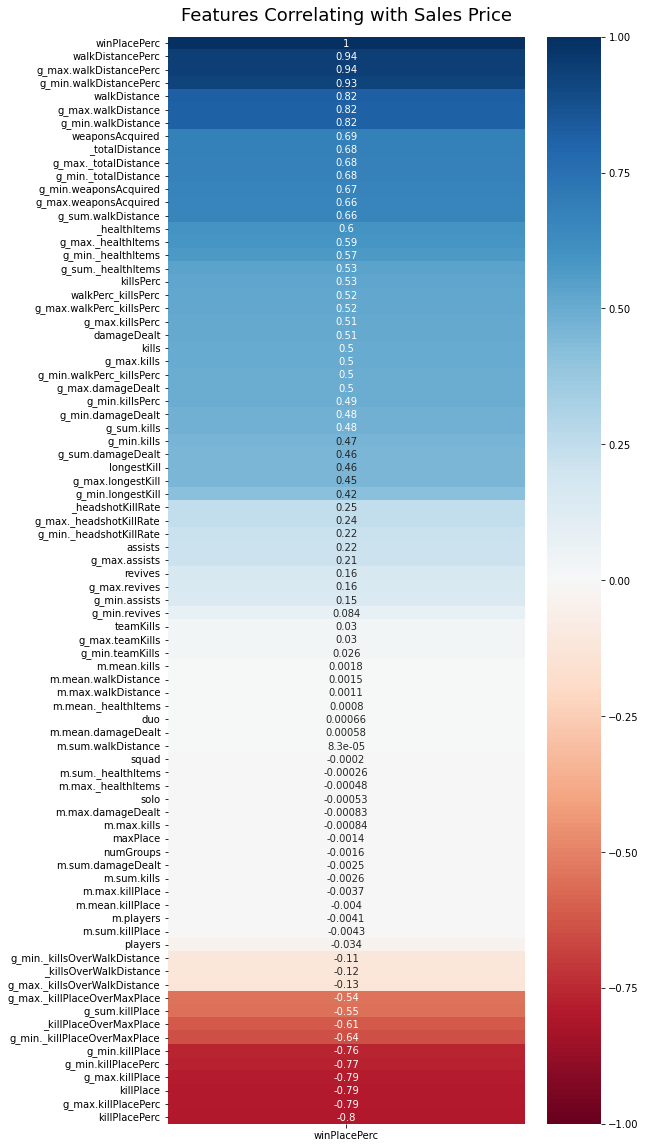

In [ ]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(all_data.corr()[['winPlacePerc']].sort_values(by='winPlacePerc', ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

# v2 - 컬럼추가

In [ ]:
# 매치타입 숫자화
mapper = lambda x: 1 if ('solo' in x) else 2 if ('duo' in x)  else 3
all_data1['matchType'] = all_data1['matchType'].apply(mapper)

In [ ]:
# 헤드샷 비율
all_data1["_Kill_headshot_Ratio"] =all_data1["headshotKills"]/ all_data1["kills"]

# killStreaks : 짧은 시간 내에 가장 많이 적을 죽인 횟수
# 짧은 시간 내 가장많이 죽인 비율
all_data1['_killStreak_Kill_ratio'] = all_data1['killStreaks']/all_data1['kills']

# 총 이동거리 =  차 타고 이동거리 + 걸은거리 + 수영한 거리
all_data1['_totalDistance'] = 0.25*all_data1['rideDistance'] + all_data1["walkDistance"] + all_data1["swimDistance"]

# maxPlace : 매치 내에서 가장 낮은 등수. 가끔 데이터가 등수를 거르기도해서 때문에 총 그룹의 수와 일치하지 않을 수 있음
# killPlace : 매치에서 킬 수 기준으로 집계한 등수
# 매치 내 킬등수 / 매치 내 가장 낮은 등수 --> ????
all_data1['_killPlace_MaxPlace_Ratio'] = all_data1['killPlace'] / all_data1['maxPlace']

# 전체 이동거리 / 무기 획득 수
# 무기 하나 획득하는데 평균 이동한 거리
all_data1['_totalDistance_weaponsAcq_Ratio'] = all_data1['_totalDistance'] / all_data1['weaponsAcquired']

# heals : 사용된 치료 아이템의 개수
# 걸은거리 /  힐템 사용수
# 힐템 하나당 이동한 거리
all_data1['_walkDistance_heals_Ratio'] = all_data1['walkDistance'] / all_data1['heals']

# 걸은 거리 /  킬 수
# 1 킬 당 움직인 평균 걸은 거리
all_data1['_walkDistance_kills_Ratio'] = all_data1['walkDistance'] / all_data1['kills']

# 킬 수 /  걸은 거리
# 1미터 걸은 거리 당  평균 킬
all_data1['_kills_walkDistance_Ratio'] = all_data1['kills'] / all_data1['walkDistance']

# matchDuration - 초 단위의 매치 시간
# 전체 이동 거리 / 매치 시간
# 매치 시간 1초당 이동한 평균 거리
all_data1['_totalDistancePerDuration'] =  all_data1["_totalDistance"]/all_data1["matchDuration"]

# killPlace : 매치에서 킬 수 기준으로 집계한 등수
# 킬 등수 / 킬 수
# 1킬당 평균 킬 등수?
all_data1['_killPlace_kills_Ratio'] = all_data1['killPlace']/all_data1['kills']

# 걸은거리 /  매치 시간
# 매치 시간 1초당 이동한 평균 걸은 거리
all_data1['_walkDistancePerDuration'] =  all_data1["walkDistance"]/all_data1["matchDuration"]

# 매치별 걸은거리로 등수 매기기
all_data1['walkDistancePerc'] = all_data1.groupby('matchId')['walkDistance'].rank(pct=True).values

# 매치별 킬로 등수 매기기
all_data1['killPerc'] = all_data1.groupby('matchId')['kills'].rank(pct=True).values

# 매치별 킬등수에따른 등수? 
all_data1['killPlacePerc'] = all_data1.groupby('matchId')['killPlace'].rank(pct=True).values

# 매치별 무기획득수에 따른 등수
all_data1['weaponsAcquired'] = all_data1.groupby('matchId')['weaponsAcquired'].rank(pct=True).values

# 걷기 등수 / 킬에 따른 등수
all_data1['_walkDistance_kills_Ratio2'] = all_data1['walkDistancePerc'] / all_data1['killPerc']

# 킬 등수 / 걷기 등수
all_data1['_kill_kills_Ratio2'] = all_data1['killPerc']/all_data1['walkDistancePerc']

# 걷기 등수 / 킬에따른 등수에 따른 등수
all_data1['_killPlace_walkDistance_Ratio2'] = all_data1['walkDistancePerc']/all_data1['killPlacePerc']

# 킬에 따른 둥수에 따른 등수 / 킬에 따른 등수
all_data1['_killPlace_kills_Ratio2'] = all_data1['killPlacePerc']/all_data1['killPerc']

# 매치별 총 이동거리로 순위매기기
all_data1['_totalDistance'] = all_data1.groupby('matchId')['_totalDistance'].rank(pct=True).values

# 걸은거리 등수 /  킬
# 1킬당 걸은거리 등수
all_data1['_walkDistance_kills_Ratio3'] = all_data1['walkDistancePerc'] / all_data1['kills']

# 킬 /  걸은 거리 등수
# 걸은 거리 등수 당 킬
all_data1['_walkDistance_kills_Ratio4'] = all_data1['kills'] / all_data1['walkDistancePerc']

# 킬 등수에 따른 등수 /  걸은 거리
# 걸은 거리당 킬 등수에 따른 등수
all_data1['_walkDistance_kills_Ratio5'] = all_data1['killPerc'] / all_data1['walkDistance']

# 걸은 거리 /  킬 등수에 따른 등수
all_data1['_walkDistance_kills_Ratio6'] = all_data1['walkDistance'] / all_data1['killPerc']

all_data1[all_data1 == np.Inf] = np.NaN
all_data1[all_data1 == np.NINF] = np.NaN
all_data1.fillna(0, inplace=True)

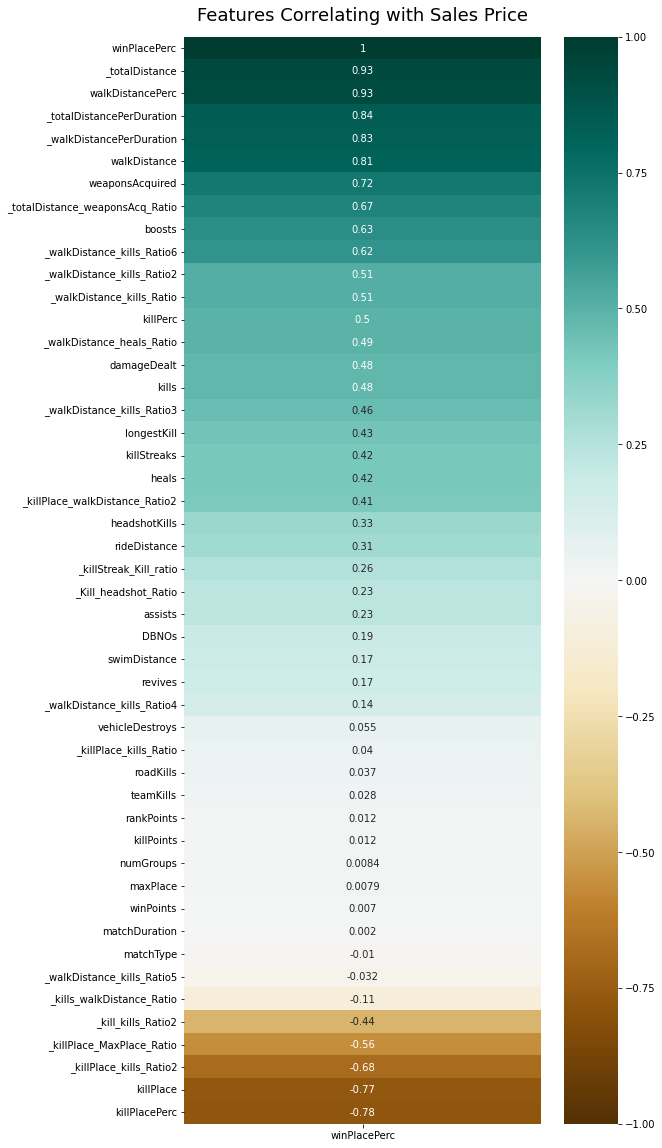

In [ ]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(all_data1.corr()[['winPlacePerc']].sort_values(by='winPlacePerc', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

# 컬럼추가만 - 스플릿

In [ ]:
train1 = all_data.copy()
train2 = all_data1.copy()

In [ ]:
# v1
X1 = train1.drop(['winPlacePerc','matchId','groupId'],axis = 1)
y1 = train1['winPlacePerc']

In [ ]:
# v2
X2 = train2.drop(['winPlacePerc','matchId','groupId','Id'],axis = 1)
y2 = train2['winPlacePerc']

In [ ]:
X_train1,X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)

In [ ]:
X_train2,X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

# 상관계수에 따른 컬럼 처리

In [ ]:
# 컬럼이름 : 타입 딕셔너리
dd_type = dict(all_data.dtypes)

# 삭제할 컬럼명
drop_list = []

# 상관 계수 DataFrame
df = all_data.corr()

for i in range(len(df.columns)):
  if (df['winPlacePerc'].tolist()[i] > - 0.1) & (df['winPlacePerc'].tolist()[i] <0.1):
    print(i)
    print(df['winPlacePerc'].tolist()[i])
    print(df.columns[i])
    drop_list.append(df.columns[i])
    print("=====")


for i in all_data.columns:
  if (dd_type[i] == object):
    drop_list.append(i)

0
-0.0339413106806216
players
=====
6
-0.001387480356803411
maxPlace
=====
7
-0.0015823475694586673
numGroups
=====
9
0.030078379759627367
teamKills
=====
28
0.029627835939909888
g_max.teamKills
=====
45
0.08409536822409287
g_min.revives
=====
46
0.025605648827980883
g_min.teamKills
=====
58
-0.004079551056040217
m.players
=====
59
-0.0026350385388508855
m.sum.kills
=====
60
-0.004278786014170543
m.sum.killPlace
=====
61
-0.002460602466731626
m.sum.damageDealt
=====
62
8.277563935487726e-05
m.sum.walkDistance
=====
63
-0.00026100417559670787
m.sum._healthItems
=====
64
-0.0008369605981351706
m.max.kills
=====
65
-0.003705849537643385
m.max.killPlace
=====
66
-0.0008284594761318692
m.max.damageDealt
=====
67
0.0010507262070267576
m.max.walkDistance
=====
68
-0.00048271226363808445
m.max._healthItems
=====
69
0.0018496863987922528
m.mean.kills
=====
70
-0.003989507292110834
m.mean.killPlace
=====
71
0.0005772787048941687
m.mean.damageDealt
=====
72
0.0014757315857092108
m.mean.walkDistan

In [ ]:
# 컬럼이름 : 타입 딕셔너리
dd_type = dict(all_data1.dtypes)

# 삭제할 컬럼명
drop_list1 = []

# 상관 계수 DataFrame
df = all_data1.corr()

for i in range(len(df.columns)):
  if (df['winPlacePerc'].tolist()[i] > - 0.1) & (df['winPlacePerc'].tolist()[i] <0.1):
    print(i)
    print(df['winPlacePerc'].tolist()[i])
    print(df.columns[i])
    drop_list1.append(df.columns[i])
    print("=====")


for i in all_data1.columns:
  if (dd_type[i] == object):
    drop_list1.append(i)

7
0.011551590436898214
killPoints
=====
11
0.00201542243662516
matchDuration
=====
12
-0.010463272398943513
matchType
=====
13
0.007882458047117536
maxPlace
=====
14
0.00836103943006525
numGroups
=====
15
0.012094881359701921
rankPoints
=====
18
0.0370023148944355
roadKills
=====
20
0.0278386699954435
teamKills
=====
21
0.05546509908392032
vehicleDestroys
=====
24
0.006995140055849436
winPoints
=====
35
0.04022839023967593
_killPlace_kills_Ratio
=====
46
-0.031540813058671395
_walkDistance_kills_Ratio5
=====


In [ ]:
all_data = all_data.drop(drop_list, axis = 1)
all_data1 = all_data1.drop(drop_list1, axis = 1)

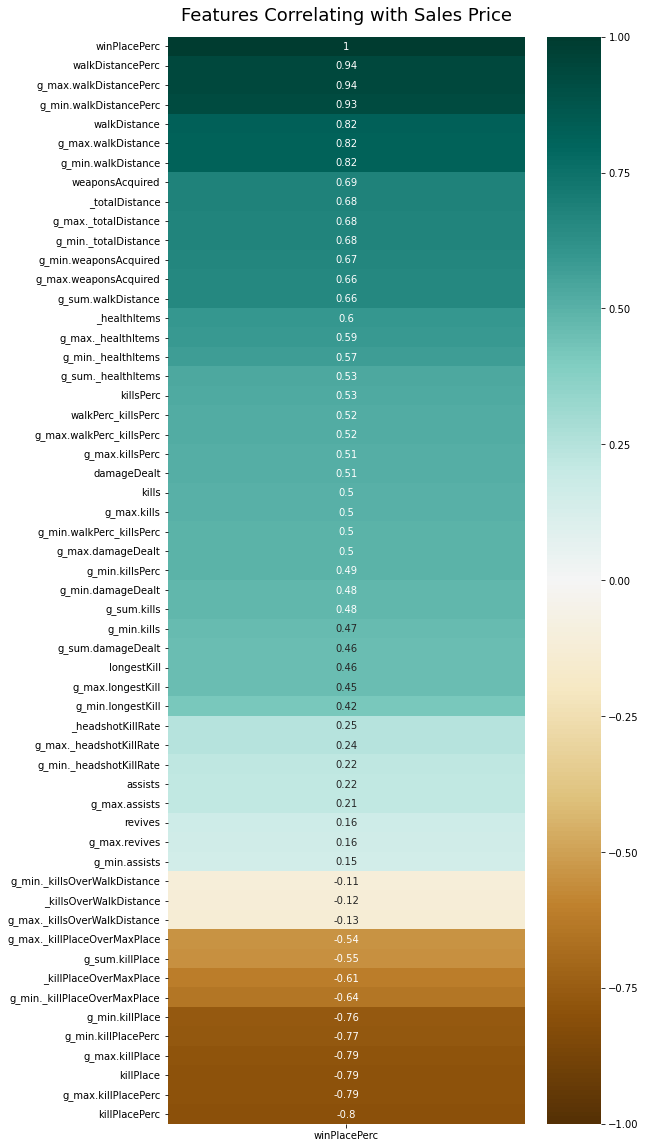

In [ ]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(all_data.corr()[['winPlacePerc']].sort_values(by='winPlacePerc', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

In [ ]:
all_data.head()

,assists,damageDealt,killPlace,kills,longestKill,revives,walkDistance,weaponsAcquired,winPlacePerc,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,g_max.assists,g_max.damageDealt,g_max.killPlace,g_max.kills,g_max.longestKill,g_max.revives,g_max.walkDistance,g_max.weaponsAcquired,g_max.killsPerc,g_max.killPlacePerc,g_max.walkDistancePerc,g_max.walkPerc_killsPerc,g_max._totalDistance,g_max._healthItems,g_max._headshotKillRate,g_max._killPlaceOverMaxPlace,g_max._killsOverWalkDistance,g_min.assists,g_min.damageDealt,g_min.killPlace,g_min.kills,g_min.longestKill,g_min.walkDistance,g_min.weaponsAcquired,g_min.killsPerc,g_min.killPlacePerc,g_min.walkDistancePerc,g_min.walkPerc_killsPerc,g_min._totalDistance,g_min._healthItems,g_min._headshotKillRate,g_min._killPlaceOverMaxPlace,g_min._killsOverWalkDistance,g_sum.kills,g_sum.killPlace,g_sum.damageDealt,g_sum.walkDistance,g_sum._healthItems
0,0.0,524.00,5.0,5.0,152.199997,0.0,1996.000000,4.0,0.8723,0.968421,0.052632,0.842105,0.869565,1996.000000,11.0,0.400000,0.052632,0.002505,0,524.00,5,5,152.199997,0,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,0.400000,0.052632,0.002505,0,524.00,5,5,152.199997,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,0.400000,0.052632,0.002505,5.0,5.0,524.00,1996.000000,11.0
1,0.0,0.00,49.5,0.0,0.000000,0.0,1432.000000,3.0,0.7128,0.289474,0.521053,0.726316,2.509091,1432.000000,3.5,0.000000,0.521053,0.000000,0,0.00,50,0,0.000000,0,1928.000000,5,0.289474,0.526316,0.831579,2.872727,1928.000000,6,0.000000,0.526316,0.000000,0,0.00,49,0,0.000000,936.000000,1,0.289474,0.515789,0.621053,2.145455,936.000000,1,0.000000,0.515789,0.000000,0.0,99.0,0.00,2864.000000,7.0
2,0.0,67.32,58.0,0.0,0.000000,0.0,447.600006,3.0,0.5000,0.289474,0.610526,0.505263,1.745455,447.600006,0.0,0.000000,0.610526,0.000000,0,67.32,58,0,0.000000,0,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,0.000000,0.610526,0.000000,0,67.32,58,0,0.000000,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,0.000000,0.610526,0.000000,0.0,58.0,67.32,447.600006,0.0
3,0.0,384.00,10.0,3.0,130.600006,0.0,1702.000000,8.0,0.9468,0.894737,0.105263,0.789474,0.882353,3716.000000,19.0,0.333333,0.105263,0.001763,0,384.00,10,3,130.600006,0,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,0.333333,0.105263,0.001763,0,384.00,10,3,130.600006,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,0.333333,0.105263,0.001763,3.0,10.0,384.00,1702.000000,19.0
4,0.0,335.00,9.0,3.0,126.400002,0.0,2881.000000,5.0,0.9894,0.894737,0.094737,0.947368,1.058824,3034.300049,6.0,1.000000,0.094737,0.001041,0,335.00,9,3,126.400002,0,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,1.000000,0.094737,0.001041,0,335.00,9,3,126.400002,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,1.000000,0.094737,0.001041,3.0,9.0,335.00,2881.000000,6.0


# 상관 계수 처리 후 스플릿

In [ ]:
train3 = all_data.copy()
train4 = all_data1.copy()

In [ ]:
train3.head()

,assists,damageDealt,killPlace,kills,longestKill,revives,walkDistance,weaponsAcquired,winPlacePerc,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,g_max.assists,g_max.damageDealt,g_max.killPlace,g_max.kills,g_max.longestKill,g_max.revives,g_max.walkDistance,g_max.weaponsAcquired,g_max.killsPerc,g_max.killPlacePerc,g_max.walkDistancePerc,g_max.walkPerc_killsPerc,g_max._totalDistance,g_max._healthItems,g_max._headshotKillRate,g_max._killPlaceOverMaxPlace,g_max._killsOverWalkDistance,g_min.assists,g_min.damageDealt,g_min.killPlace,g_min.kills,g_min.longestKill,g_min.walkDistance,g_min.weaponsAcquired,g_min.killsPerc,g_min.killPlacePerc,g_min.walkDistancePerc,g_min.walkPerc_killsPerc,g_min._totalDistance,g_min._healthItems,g_min._headshotKillRate,g_min._killPlaceOverMaxPlace,g_min._killsOverWalkDistance,g_sum.kills,g_sum.killPlace,g_sum.damageDealt,g_sum.walkDistance,g_sum._healthItems
0,0.0,524.00,5.0,5.0,152.199997,0.0,1996.000000,4.0,0.8723,0.968421,0.052632,0.842105,0.869565,1996.000000,11.0,0.400000,0.052632,0.002505,0,524.00,5,5,152.199997,0,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,0.400000,0.052632,0.002505,0,524.00,5,5,152.199997,1996.000000,4,0.968421,0.052632,0.842105,0.869565,1996.000000,11,0.400000,0.052632,0.002505,5.0,5.0,524.00,1996.000000,11.0
1,0.0,0.00,49.5,0.0,0.000000,0.0,1432.000000,3.0,0.7128,0.289474,0.521053,0.726316,2.509091,1432.000000,3.5,0.000000,0.521053,0.000000,0,0.00,50,0,0.000000,0,1928.000000,5,0.289474,0.526316,0.831579,2.872727,1928.000000,6,0.000000,0.526316,0.000000,0,0.00,49,0,0.000000,936.000000,1,0.289474,0.515789,0.621053,2.145455,936.000000,1,0.000000,0.515789,0.000000,0.0,99.0,0.00,2864.000000,7.0
2,0.0,67.32,58.0,0.0,0.000000,0.0,447.600006,3.0,0.5000,0.289474,0.610526,0.505263,1.745455,447.600006,0.0,0.000000,0.610526,0.000000,0,67.32,58,0,0.000000,0,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,0.000000,0.610526,0.000000,0,67.32,58,0,0.000000,447.600006,3,0.289474,0.610526,0.505263,1.745455,447.600006,0,0.000000,0.610526,0.000000,0.0,58.0,67.32,447.600006,0.0
3,0.0,384.00,10.0,3.0,130.600006,0.0,1702.000000,8.0,0.9468,0.894737,0.105263,0.789474,0.882353,3716.000000,19.0,0.333333,0.105263,0.001763,0,384.00,10,3,130.600006,0,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,0.333333,0.105263,0.001763,0,384.00,10,3,130.600006,1702.000000,8,0.894737,0.105263,0.789474,0.882353,3716.000000,19,0.333333,0.105263,0.001763,3.0,10.0,384.00,1702.000000,19.0
4,0.0,335.00,9.0,3.0,126.400002,0.0,2881.000000,5.0,0.9894,0.894737,0.094737,0.947368,1.058824,3034.300049,6.0,1.000000,0.094737,0.001041,0,335.00,9,3,126.400002,0,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,1.000000,0.094737,0.001041,0,335.00,9,3,126.400002,2881.000000,5,0.894737,0.094737,0.947368,1.058824,3034.300049,6,1.000000,0.094737,0.001041,3.0,9.0,335.00,2881.000000,6.0


In [ ]:
# v1 + 상관
X3 = train3.drop('winPlacePerc',axis = 1)
y3 = train3['winPlacePerc']

In [ ]:
# v2 + 상관
X4 = train4.drop('winPlacePerc',axis = 1)
y4 = train4['winPlacePerc']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20406 entries, 105 to 452866
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   assists          20406 non-null  int8   
 1   boosts           20406 non-null  int8   
 2   damageDealt      20406 non-null  float32
 3   DBNOs            20406 non-null  int8   
 4   headshotKills    20406 non-null  int8   
 5   heals            20406 non-null  int8   
 6   killPlace        20406 non-null  int8   
 7   killPoints       20406 non-null  int16  
 8   kills            20406 non-null  int8   
 9   killStreaks      20406 non-null  int8   
 10  longestKill      20406 non-null  float32
 11  matchDuration    20406 non-null  int16  
 12  matchType        20406 non-null  object 
 13  maxPlace         20406 non-null  int8   
 14  numGroups        20406 non-null  int8   
 15  rankPoints       20406 non-null  int16  
 16  revives          20406 non-null  int8   
 17  rideDista

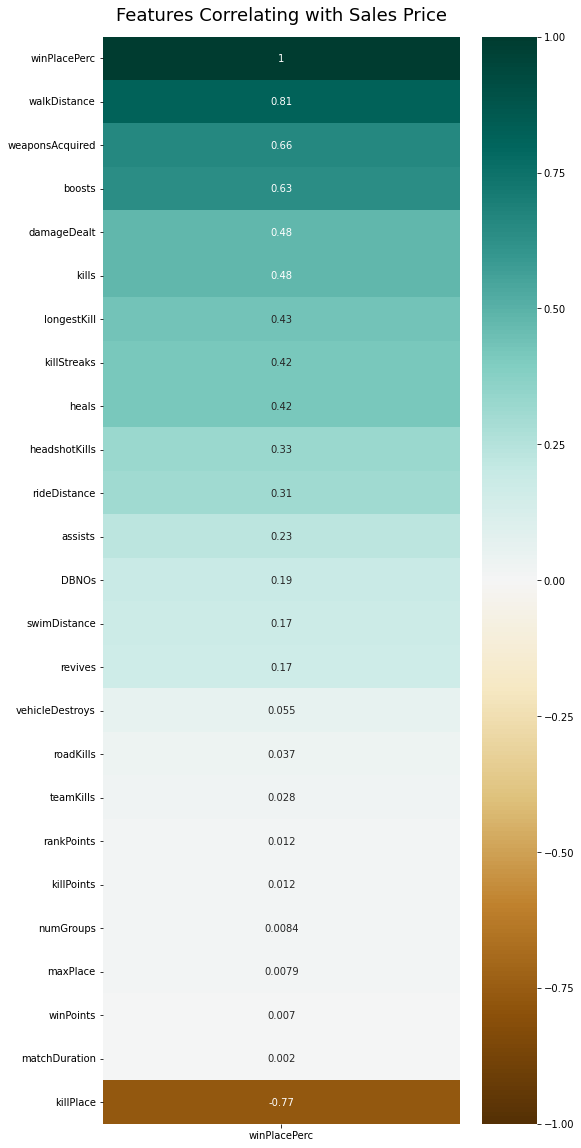

In [ ]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(train.corr()[['winPlacePerc']].sort_values(by='winPlacePerc', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

In [ ]:
X_train3,X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2)
X_train4,X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2)

In [ ]:
X_test.shape

(4082, 25)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15798 entries, 0 to 15797
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   assists                       15798 non-null  float32
 1   damageDealt                   15798 non-null  float32
 2   killPlace                     15798 non-null  float32
 3   kills                         15798 non-null  float32
 4   longestKill                   15798 non-null  float32
 5   revives                       15798 non-null  float32
 6   walkDistance                  15798 non-null  float32
 7   weaponsAcquired               15798 non-null  float32
 8   winPlacePerc                  15798 non-null  float32
 9   killsPerc                     15798 non-null  float32
 10  killPlacePerc                 15798 non-null  float32
 11  walkDistancePerc              15798 non-null  float32
 12  walkPerc_killsPerc            15798 non-null  float32
 13  _

# 다중공선성

In [ ]:
# 컬럼이름 : 타입 딕셔너리
dd_type = dict(all_data.dtypes)

# 삭제할 컬럼명
drop_list = []

for i in all_data.columns:
  if (dd_type[i] == object):
    drop_list.append(i)
all_data = all_data.drop(drop_list, axis = 1)

In [ ]:
# 컬럼이름 : 타입 딕셔너리
dd_type = dict(all_data1.dtypes)

# 삭제할 컬럼명
drop_list1 = []

for i in all_data1.columns:
  if (dd_type[i] == object):
    drop_list1.append(i)
all_data1 = all_data1.drop(drop_list1, axis = 1)

In [ ]:
X5 = all_data.copy() # 문자열로 된 컬럼들 전부 삭제
X5.pop("winPlacePerc")

X6 = all_data1.copy() # 문자열로 된 컬럼들 전부 삭제
X6.pop("winPlacePerc")

105       0.2500
115       0.9592
178       0.6875
180       0.3125
181       0.3191
           ...  
452747    0.5914
452748    0.3191
452793    0.2935
452835    0.4348
452866    0.7526
Name: winPlacePerc, Length: 20406, dtype: float32

In [ ]:
X6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20406 entries, 105 to 452866
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   assists                          20406 non-null  int8   
 1   boosts                           20406 non-null  int8   
 2   damageDealt                      20406 non-null  float32
 3   DBNOs                            20406 non-null  int8   
 4   headshotKills                    20406 non-null  int8   
 5   heals                            20406 non-null  int8   
 6   killPlace                        20406 non-null  int8   
 7   kills                            20406 non-null  int8   
 8   killStreaks                      20406 non-null  int8   
 9   longestKill                      20406 non-null  float32
 10  revives                          20406 non-null  int8   
 11  rideDistance                     20406 non-null  float32
 12  swimDistance   

In [ ]:
# all_data.copy()
# all_data1.copy()

In [ ]:
def scaler(X):
  scaler = MinMaxScaler()
  scaler.fit(X)
  vif_X_scaler = scaler.transform(X)

  # vif_X_scaler 를 DataFrame으로 변환
  vif_X = pd.DataFrame(vif_X_scaler, columns = X.columns)

  return vif_X

In [ ]:
data = scaler(X5)
data1 = scaler(X6)

In [ ]:
# 다중공산성 처리 함수
def vif_df(data):
  while True:
    #다중 공선성 지수를 저장할 데이터 프레임 vif 생성
    vif = pd.DataFrame()

    vif["VIF Factor"] = [ variance_inflation_factor(data.values,i) for i in range(data.shape[1])]

    # 데이터 프레임의 vif features 컬럼에 vif_X 컬럼명 대입
    vif["features"] = data.columns

    # 제일 큰값의 인덱스 추출
    idx = vif['VIF Factor'].argmax()

    # 해당 인덱스의 컬럼명 추출
    drop_col = vif.iloc[idx]['features']
    print(drop_col)

    # 기존 데이터에서 컬렴명 드롭
    data = data.drop(drop_col, axis =1).reset_index( drop = True)

    # 10 보다 작으면 중지
    if vif['VIF Factor'].values.max() < 10:
      break
  return data

In [ ]:
data = vif_df(data)

killPlacePerc
killPlace
walkDistancePerc
killsPerc
walkDistance
g_min.killPlacePerc
weaponsAcquired
_totalDistance
walkPerc_killsPerc
kills
damageDealt
_healthItems
_killsOverWalkDistance
_killPlaceOverMaxPlace
g_max.killPlace
longestKill
_headshotKillRate
g_max.walkDistancePerc
g_max.killPlacePerc
g_max.killsPerc
assists
g_sum.kills
g_max.walkDistance
g_min.walkDistancePerc
g_max._totalDistance
g_max.damageDealt
g_max.walkPerc_killsPerc
g_max._healthItems
g_min._killPlaceOverMaxPlace
g_max.weaponsAcquired
g_min.kills
g_min.walkDistance
g_sum.damageDealt
g_max._killPlaceOverMaxPlace
g_max.revives
g_sum._healthItems


In [ ]:
data1 = vif_df(data1)

_totalDistancePerDuration
walkDistancePerc
killPlacePerc
_totalDistance
walkDistance
killPlace
kills
_walkDistance_kills_Ratio3
_walkDistancePerDuration
killPerc
_walkDistance_kills_Ratio2
killStreaks
damageDealt


# 다중 공선성 처리후 스플릿


In [ ]:
# 다중공선성을 정리한 컬럼들을 독립변수들을 X에 대입 

X5 = all_data.loc[:, data.columns]
X5
# 우리가 알고싶은 우승자 예측 값을 y에 대입
y5 =all_data["winPlacePerc"]

In [ ]:
# 다중공선성을 정리한 컬럼들을 독립변수들을 X에 대입 

X6 = all_data1.loc[:, data1.columns]
X6
# 우리가 알고싶은 우승자 예측 값을 y에 대입
y6 =all_data1["winPlacePerc"]


In [ ]:
X_train5,X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2)
X_train6,X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.2)

# 머신 5개 예측 -> 결과 to DataFrame

- Train1 - 컬럼추가 Version 1

- Train2 - 컬럼추가 Version 2

- Train3 - 컬럼추가 Version1 + 상관계수 절댓값 0.1 이하인것들 삭제

- Train4 - 컬럼추가 Version2 + 상관계수 절댓값 0.1 이하인것들 삭제

- Train5 - 컬럼추가 Version1 + 상관계수 절댓값 0.1 이하인것들 삭제 + 다중공산성 

- Train6 - 컬럼추가 Version2 + 상관계수 절댓값 0.1 이하인것들 삭제+ 다중 공산성

In [ ]:
# xgboost
model_xgb = XGBRegressor(
    objective='reg:squarederror',
    booster = 'gbtree',
    colsample_bytree = 0.8,
    colsample_bylevel = 0.9,
    n_estimators = 200, 
    max_depth = 8, 
    min_child_weight=5, 
    learning_rate = 0.1 
)

# lgbm
model_lgb = LGBMRegressor(
    n_estimators = 3000,
    max_depth = 8,
    min_child_weight = 8,
    learning_rate = 0.1
)

# GradientBoostingRegressor
model_gbr = GradientBoostingRegressor(
    alpha = 0.9, 
    learning_rate=0.1, 
    max_depth = 7 ,
    n_estimators = 200 ,
    subsample = 0.9
    )

# Extra Trees Regressor
et_model=ExtraTreesRegressor( n_estimators = 200 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )

# random forest
model_rf = RandomForestRegressor( n_estimators = 500 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )

In [ ]:
model_list = [model_xgb, model_lgb, model_gbr, et_model,model_rf]

In [ ]:
for i in model_list:
  print(i)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=5, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=8, min_split_gain=0.0,
              n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criteri

In [ ]:
# model
model_list = [model_xgb, model_lgb, model_gbr, et_model,model_rf]

# X_train
X_train_list = [X_train1, X_train2, X_train3, X_train4,X_train5,X_train6]

# y_train
y_train_list = [y_train1, y_train2, y_train3, y_train4,y_train5,y_train6]

# X_test
X_test_list = [X_test1, X_test2, X_test3, X_test4,X_test5,X_test6]

# y_test
y_test_list = [y_test1, y_test2, y_test3, y_test4,y_test5,y_test6]

In [ ]:
df = pd.DataFrame(columns = ['data','mse' , 'mae', 'r2','rmse'])

str1 = ["컬럼V1" ,"컬럼V2"]
str2 = ["_상관 계수","_상관+다중"] 
score = ['mse' , 'mae', 'r2','rmse']
model_name = ["_xgb",'_lgbm','_gbr','_et','_rf']

cnt = 0
num = 0


for i in model_list:
  for j in range(len(X_train_list)):
    
    # i번쨰 모델 학습
    i.fit(X_train_list[j],y_train_list[j])

    # i번쨰 모델 예측
    pred = i.predict(X_test_list[j])

    # 성능 측정
    mse = mean_squared_error(pred, y_test_list[j])
    mae = mean_absolute_error(pred, y_test_list[j])
    r2 = r2_score(pred, y_test_list[j])
    rmse = np.sqrt(mean_squared_error(pred, y_test_list[j]))

    # train1, train2는 컬럼만 추가한 데이터 셋
    if j < 2: 
      df.loc[num + j] = [str1[j] + model_name[cnt], mse , mae, r2, rmse]

    # train3, train4는 컬럼추가 후 상관계수의 절댓값이 0.1보다 작은것을 제거한 데이터 셋
    # 따라서  str2(_상관 계수) 문자열을 추가해 줌
    elif j< 4:
      df.loc[num + j] = [str1[(j%2)] + str2[0] + model_name[cnt], mse , mae, r2, rmse]
    else:
      df.loc[num + j] = [str1[(j%2)] + str2[1] + model_name[cnt], mse , mae, r2, rmse]
  
  # 데이터프레임 덮어쓰기 방지
  cnt += 1
  num += 6
  print(df)

             data       mse       mae        r2      rmse
0        컬럼V1_xgb  0.002144  0.031235  0.974671  0.046308
1        컬럼V2_xgb  0.002591  0.034594  0.969611  0.050899
2  컬럼V1_상관 계수_xgb  0.002488  0.035063  0.969948  0.049880
3  컬럼V2_상관 계수_xgb  0.003052  0.037726  0.963746  0.055242
4  컬럼V1_상관+다중_xgb  0.004017  0.044772  0.949616  0.063382
5  컬럼V2_상관+다중_xgb  0.004434  0.047003  0.946822  0.066590
               data       mse       mae        r2      rmse
0          컬럼V1_xgb  0.002144  0.031235  0.974671  0.046308
1          컬럼V2_xgb  0.002591  0.034594  0.969611  0.050899
2    컬럼V1_상관 계수_xgb  0.002488  0.035063  0.969948  0.049880
3    컬럼V2_상관 계수_xgb  0.003052  0.037726  0.963746  0.055242
4    컬럼V1_상관+다중_xgb  0.004017  0.044772  0.949616  0.063382
5    컬럼V2_상관+다중_xgb  0.004434  0.047003  0.946822  0.066590
6         컬럼V1_lgbm  0.001795  0.028255  0.979044  0.042363
7         컬럼V2_lgbm  0.002327  0.032307  0.973001  0.048240
8   컬럼V1_상관 계수_lgbm  0.002359  0.034534  0.971766  0.0

In [ ]:
df

,data,mse,mae,r2,rmse
0,컬럼V1_xgb,0.002144,0.031235,0.974671,0.046308
1,컬럼V2_xgb,0.002591,0.034594,0.969611,0.050899
2,컬럼V1_상관 계수_xgb,0.002488,0.035063,0.969948,0.049880
3,컬럼V2_상관 계수_xgb,0.003052,0.037726,0.963746,0.055242
4,컬럼V1_상관+다중_xgb,0.004017,0.044772,0.949616,0.063382
5,컬럼V2_상관+다중_xgb,0.004434,0.047003,0.946822,0.066590
6,컬럼V1_lgbm,0.001795,0.028255,0.979044,0.042363
7,컬럼V2_lgbm,0.002327,0.032307,0.973001,0.048240
8,컬럼V1_상관 계수_lgbm,0.002359,0.034534,0.971766,0.048570
9,컬럼V2_상관 계수_lgbm,0.002867,0.036646,0.966300,0.053547


In [ ]:
df.sort_values('mae').head(10)

,data,mse,mae,r2,rmse
6,컬럼V1_lgbm,0.001795,0.028255,0.979044,0.042363
0,컬럼V1_xgb,0.002144,0.031235,0.974671,0.046308
12,컬럼V1_gbr,0.002167,0.031767,0.974316,0.046548
7,컬럼V2_lgbm,0.002327,0.032307,0.973001,0.048240
8,컬럼V1_상관 계수_lgbm,0.002359,0.034534,0.971766,0.048570
1,컬럼V2_xgb,0.002591,0.034594,0.969611,0.050899
2,컬럼V1_상관 계수_xgb,0.002488,0.035063,0.969948,0.049880
14,컬럼V1_상관 계수_gbr,0.002454,0.035216,0.970408,0.049535
13,컬럼V2_gbr,0.002681,0.035476,0.968648,0.051776
9,컬럼V2_상관 계수_lgbm,0.002867,0.036646,0.966300,0.053547


# XGB

In [ ]:
# 1
model = xgb.XGBRegressor()

# 2
param_grid={'booster' :['gbtree'],
                 'silent':[True], # default = 0, 1 = 동작메시지를 프린트하지 않음
                 'max_depth':[5,6,8], # 트리의 최대 깊이
                 'min_child_weight':[1,3,5], # over-fitting vs under-fitting을 조정하기 위한 파라미터
                 'gamma':[0,1,2,3], # 분할을 수행하는데 필요한 최소 손실 감소를 지정
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8], #  default = 1 , 각 트리마다의 feature 샘플링 비율.
                 'colsample_bylevel':[0.9], # 각 level마다 샘플링 비율
                 'n_estimators':[50],
                }


# 3번
cv=KFold(n_splits=6, random_state=1)

# 4번
gcv=GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=4)

# 5번
gcv.fit(train_X.values,train_Y.values)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
print('best score', gcv.best_score_)      # 최고의 점수



In [ ]:
# XGboost
model_xgb = XGBRegressor(
    objective='reg:squarederror'
    )
model_xgb.fit(
    X_train1, y_train1
    )
pred = model_xgb.predict(X_test1)

print("XGB 기본 튜닝")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

XGB 기본 튜닝
MSE : 0.003580
MAE : 0.043035
R2_Score : 0.955746
RMSE : 0.059835


v2 -기본

In [ ]:
# XGboost
model_xgb2 = XGBRegressor(
    booster = 'gbtree',
    colsample_bytree = 0.8,
    colsample_bylevel = 0.9,
    n_estimators = 200, 
    max_depth = 8, 
    min_child_weight=5, 
    learning_rate = 0.1 
)

model_xgb2.fit(X_train2, y_train2)
pred = model_xgb2.predict(X_test2)

[07:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test2)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test2)))
print("R2_Score : {:.6f}".format(mean_absolute_error(pred, y_test2)))
print("RMSE : {:.6f}".format(mean_absolute_error(pred, y_test2)))

MSE : 0.002708
MAE : 0.035260
R2_Score : 0.035260
RMSE : 0.035260


v2+ 상관

In [ ]:
# XGboost
model_xgb4 = XGBRegressor(
    booster = 'gbtree',
    colsample_bytree = 0.8,
    colsample_bylevel = 0.9,
    n_estimators = 200, 
    max_depth = 8, 
    min_child_weight=5, 
    learning_rate = 0.1 
)

model_xgb4.fit(X_train4, y_train4)
pred = model_xgb4.predict(X_test4)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test4)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test4)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test4)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test4))))

[09:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE : 0.003060
MAE : 0.037503
R2_Score : 0.962913
RMSE : 0.055314


v1  

In [ ]:
# XGboost
model_xgb1 = XGBRegressor(
    objective='reg:squarederror',
    booster = 'gbtree',
    colsample_bytree = 0.8,
    colsample_bylevel = 0.9,
    n_estimators = 200, 
    max_depth = 8, 
    min_child_weight=5, 
    learning_rate = 0.1 
)

model_xgb1.fit(X_train1, y_train1)
pred = model_xgb1.predict(X_test1)

print("XGB 튜닝 후")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

XGB 튜닝 후
MSE : 0.002183
MAE : 0.032009
R2_Score : 0.973852
RMSE : 0.046725


v3

In [ ]:
# XGboost
model_xgb3 = XGBRegressor(
    booster = 'gbtree',
    colsample_bytree = 0.8,
    colsample_bylevel = 0.9,
    n_estimators = 200, 
    max_depth = 8, 
    min_child_weight=5, 
    learning_rate = 0.1 
)

model_xgb3.fit(X_train3, y_train3)
pred = model_xgb3.predict(X_test3)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test3)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test3)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test3)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test3))))

[09:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE : 0.002490
MAE : 0.035025
R2_Score : 0.970173
RMSE : 0.049900


# XGB.GridCV

In [ ]:
X['matchType']

In [ ]:
X

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,992995bd23ab4a,0,0,36.01,0,0,0,74,1108,0,0,0.000,1300,2,49,49,-1,0,0.0000,0,0.00,0,0,206.30,2,1498
1,59ff1f04f1fdbf,0,5,216.70,0,0,0,26,1507,1,1,114.900,1436,2,50,50,-1,1,0.0071,0,26.49,0,0,4062.00,3,1664
2,a3a80601eaab75,1,2,722.40,0,1,0,2,1320,5,1,97.430,1296,1,97,97,-1,0,0.0000,0,0.00,0,0,625.60,4,1467
3,875e1bf0894e85,0,0,43.00,0,0,0,41,0,1,1,12.360,1415,1,97,96,1491,0,0.0000,0,0.00,0,0,114.30,2,0
4,5ae9e22a50dd8e,0,0,162.10,2,0,0,35,0,1,1,9.456,1430,2,48,48,1441,0,0.0000,0,0.00,0,0,118.30,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20401,26b0706bf32a63,0,2,100.00,0,1,5,27,0,1,1,34.980,1353,1,94,93,1504,0,0.0000,0,0.00,0,0,711.60,3,0
20402,bd41c891688e6b,0,0,0.00,0,0,0,73,0,0,0,0.000,1377,1,95,94,1712,0,0.0000,0,0.00,0,0,97.64,3,0
20403,54dee53f63024a,0,0,0.00,0,0,0,68,0,0,0,0.000,1366,1,93,90,1484,0,0.0000,0,0.00,0,0,46.80,3,0
20404,eb60c7ab9cd137,0,0,171.00,0,0,0,41,0,1,1,12.800,1441,1,93,90,1517,0,0.0000,0,0.00,0,0,61.10,1,0


In [ ]:
train.iloc[:,4:-1]

In [ ]:
params = {
    'booster' :['gbtree'],
    "n_estimators":[100,200], # 트리 개수 100개
    "max_depth":[6, 8, 10, 12], # 최대 트리의 깊이 6, 8,10 ,12
    'min_child_weight':[1,3,5], # 최소 트리잎의 개수
    'colsample_bytree':[0.5,0.8], # 전체 데이터 로우 중에서 
    'colsample_bylevel':[0.9],      # 최소 몇개의 데이터를 이용해서 트리를 만들거냐
}

model = xgb.XGBRegressor(n_jobs = 10)

cv = KFold(n_splits=6)

gcv = GridSearchCV(model,param_grid=params,cv=cv, n_jobs=10)

gcv.fit(X_train,y_train)

print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
print('best score', gcv.best_score_)      # 최고의 점수

[14:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
final params {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 200}
best score 0.9524738243414516


In [ ]:
model=gcv.best_estimator_ # 최적의 파라미터로 모델 생성
preds = model.predict(X_test) # refit=True이기때문에 좋은 estimator로 바로 적용되서 예측  # refit =True가 Default값

In [ ]:
print("MSE :",mean_squared_error(preds, y_test))
print("MAE :",mean_absolute_error(preds, y_test))

MSE : 0.004086553819168092
MAE : 0.043078114113686186


In [ ]:
  xgb.plot_tree(model, num_trees=0, rankdir='LR')

  fig = plt.gcf()
  fig.set_size_inches(150, 100)

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# LGBM

In [ ]:
model_lgb = LGBMRegressor()
model_lgb.fit(
              X_train1,
              y_train1
              )
pred = model_lgb.predict(X_test1)

print("LGBM 기본 튜닝")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

LGBM 기본 튜닝
MSE : 0.002397
MAE : 0.034745
R2_Score : 0.971093
RMSE : 0.048962


- 기본 튜닝

In [ ]:
model_lgb = LGBMRegressor(
    n_estimators = 3000,
    max_depth = 8,
    min_child_weight = 8,
    learning_rate = 0.1
)
model_lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=8, min_split_gain=0.0,
              n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
predictions = model_lgb.predict(X_test)
print("MSE : {:.10f}".format(mean_squared_error(predictions, y_test)))
print("MAE :",mean_absolute_error(predictions, y_test))

MSE : 0.0000009335
MAE : 0.0007045225578530712


기본

In [ ]:
model_lgb = LGBMRegressor(
    n_estimators = 3000,
    max_depth = 8,
    min_child_weight = 8,
    learning_rate = 0.1
)
model_lgb.fit(X_train, y_train)
pred = model_lgb.predict(X_test)
print("MSE : {:.10f}".format(mean_squared_error(predictions, y_test)))
print("MAE :",mean_absolute_error(predictions, y_test))

MSE : 0.0033562378
MAE : 0.03864995057850627


현준 - 기본

In [ ]:
model_lgb2 = LGBMRegressor(
    n_estimators = 3000,
    max_depth = 8,
    min_child_weight = 8,
    learning_rate = 0.1
)
model_lgb2.fit(X_train2, y_train2)

pred = model_lgb2.predict(X_test2)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test2)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test2)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test2)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test2))))

MSE : 0.002374
MAE : 0.033133
R2_Score : 0.972134
RMSE : 0.048724


In [ ]:
컬럼V2_lgbm_mse = mean_squared_error(pred, y_test2)
컬럼V2_lgbm_mae = mean_absolute_error(pred, y_test2)
컬럼V2_lgbm_r2 = r2_score(pred, y_test2)
컬럼V2_lgbm_rmse = np.sqrt(mean_squared_error(pred, y_test2))

현준 - 상관

In [ ]:
model_lgb4 = LGBMRegressor(
    n_estimators = 3000,
    max_depth = 8,
    min_child_weight = 8,
    learning_rate = 0.1
)
model_lgb4.fit(X_train4, y_train4)

pred = model_lgb4.predict(X_test4)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test4)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test4)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test4)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test4))))

MSE : 0.002944
MAE : 0.036032
R2_Score : 0.964739
RMSE : 0.054257


In [ ]:
컬럼V2_상관_lgbm_mse = mean_squared_error(pred, y_test4)
컬럼V2_상관_lgbm_mae = mean_absolute_error(pred, y_test4)
컬럼V2_상관_lgbm_r2 = r2_score(pred, y_test4)
컬럼V2_상관_lgbm_rmse = np.sqrt(mean_squared_error(pred, y_test4))

민준햄

In [ ]:
model_lgb1 = LGBMRegressor(
    n_estimators = 3000,
    max_depth = 8,
    min_child_weight = 8,
    learning_rate = 0.1
)
model_lgb1.fit(X_train1, y_train1)

pred = model_lgb1.predict(X_test1)


print("LGBM 튜닝 후")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

LGBM 튜닝 후
MSE : 0.001824
MAE : 0.028996
R2_Score : 0.978319
RMSE : 0.042707


In [ ]:
컬럼V1_lgbm_mse = mean_squared_error(pred, y_test1)
컬럼V1_lgbm_mae = mean_absolute_error(pred, y_test1)
컬럼V1_lgbm_r2 = r2_score(pred, y_test1)
컬럼V1_lgbm_rmse = np.sqrt(mean_squared_error(pred, y_test1))

민줌햄 -상관

In [ ]:
model_lgb3 = LGBMRegressor(
    n_estimators = 3000,
    max_depth = 8,
    min_child_weight = 8,
    learning_rate = 0.1
)
model_lgb3.fit(X_train3, y_train3)

pred = model_lgb3.predict(X_test3)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test3)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test3)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test3)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test3))))

MSE : 0.002427
MAE : 0.034942
R2_Score : 0.971185
RMSE : 0.049262


In [ ]:
컬럼V1_상관_lgbm_mse = mean_squared_error(pred, y_test3)
컬럼V1_상관_lgbm_mae = mean_absolute_error(pred, y_test3)
컬럼V1_상관_lgbm_r2 = r2_score(pred, y_test3)
컬럼V1_상관_lgbm_rmse = np.sqrt(mean_squared_error(pred, y_test3))

# lgbm GridCV

In [ ]:
params = {
    'n_estimators': [500, 1000,2000,3000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [7, 8], 
    'colsample_bytree': [0.8, 0.9], 
    'subsample': [0.8, 0.9,],
}

model_lgb = LGBMRegressor()

grid_search = GridSearchCV(model_lgb, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

lgbm_best = grid_search.best_estimator_

lgbm_best.fit(X_train, y_train)

predictions = lgbm_best.predict(X_test)



In [ ]:
params = {
    'n_estimators': [500, 1000,2000,3000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [7, 8], 
    'colsample_bytree': [0.8, 0.9], 
    'subsample': [0.8, 0.9,],
}

model_lgb = LGBMRegressor()

grid_search = GridSearchCV(model_lgb, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')


In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [7, 8],
                  

In [ ]:
print(grid_search.best_params_)

{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 3000, 'subsample': 0.8}


In [ ]:
lgbm_best = grid_search.best_estimator_
lgbm_best.fit(X_train, y_train)
predictions = lgbm_best.predict(X_test)

In [ ]:
print("MSE : {:.10f}".format(mean_squared_error(predictions, y_test)))
print("MAE :",mean_absolute_error(predictions, y_test))

MSE : 0.0035201037
MAE : 0.0393122307993788


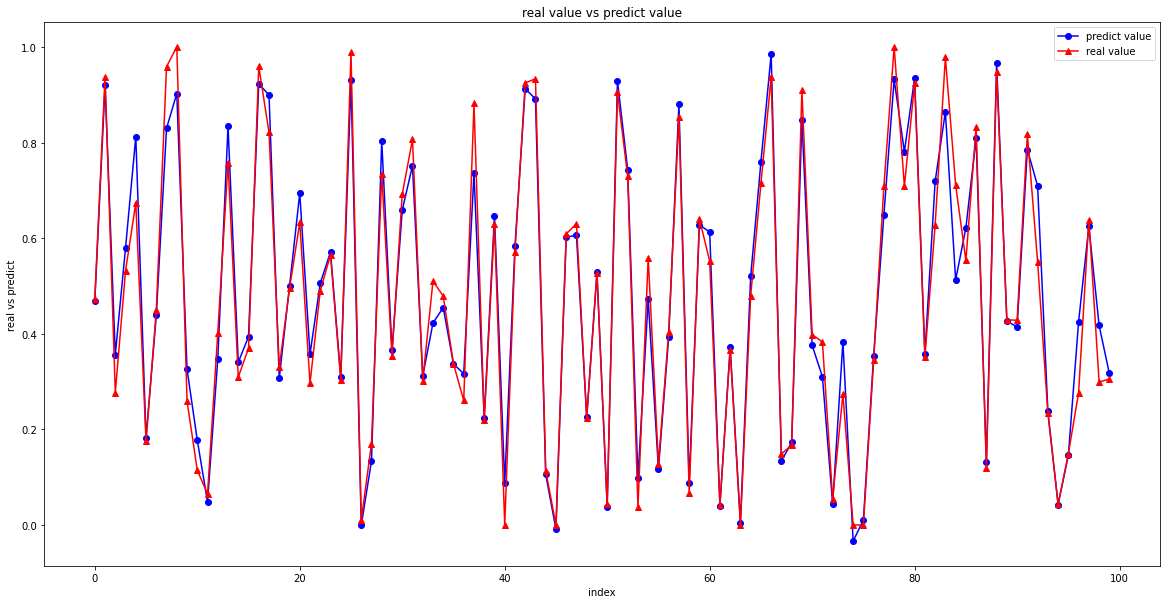

In [ ]:
fig = plt.figure( figsize = (20, 10) )
chart = fig.add_subplot(1,1,1)
chart.plot(predictions[:100], marker='o', color='blue', label='predict value')
chart.plot(y_test.values[:100], marker='^', color='red', label='real value')
chart.set_title('real value vs predict value')
plt.xlabel('index')
plt.ylabel('real vs predict')
plt.legend(loc = 'best') 

# lgbm 그래프

In [ ]:
from pandas.plotting import scatter_matrix
from lightgbm import plot_importance
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
model_lgb1 = LGBMRegressor(
    n_estimators = 3000,
    max_depth = 8,
    min_child_weight = 8,
    learning_rate = 0.1
)
model_lgb1.fit(X_train1, y_train1)

pred = model_lgb1.predict(X_test1)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

MSE : 0.001864
MAE : 0.028811
R2_Score : 0.977205
RMSE : 0.043171


In [ ]:
print("트레이닝 셋 정확도 : {:.4f}".format(model_lgb1.score(X_train1, y_train1)))

print("테스트 셋 정확도 : {:.4f}".format(model_lgb1.score(X_test1, y_test1)))

트레이닝 셋 정확도 : 0.9999
테스트 셋 정확도 : 0.9778


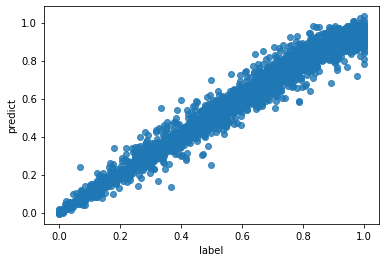

In [ ]:
final_result = pd.concat([y_test1.reset_index(drop=True), pd.DataFrame(pred)], axis = 1)
final_result.columns = ['label','predict']
sns.regplot(x = 'label', y = 'predict', data = final_result)


In [ ]:
boost =  model_lgb1.booster_

In [ ]:
print('Feature names',boost.feature_name())

Feature names ['players', 'assists', 'damageDealt', 'killPlace', 'kills', 'longestKill', 'maxPlace', 'numGroups', 'revives', 'teamKills', 'walkDistance', 'weaponsAcquired', 'killsPerc', 'killPlacePerc', 'walkDistancePerc', 'walkPerc_killsPerc', '_totalDistance', '_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', 'g_max.assists', 'g_max.damageDealt', 'g_max.killPlace', 'g_max.kills', 'g_max.longestKill', 'g_max.revives', 'g_max.teamKills', 'g_max.walkDistance', 'g_max.weaponsAcquired', 'g_max.killsPerc', 'g_max.killPlacePerc', 'g_max.walkDistancePerc', 'g_max.walkPerc_killsPerc', 'g_max._totalDistance', 'g_max._healthItems', 'g_max._headshotKillRate', 'g_max._killPlaceOverMaxPlace', 'g_max._killsOverWalkDistance', 'g_min.assists', 'g_min.damageDealt', 'g_min.killPlace', 'g_min.kills', 'g_min.longestKill', 'g_min.revives', 'g_min.teamKills', 'g_min.walkDistance', 'g_min.weaponsAcquired', 'g_min.killsPerc', 'g_min.killPlacePerc', 'g_min.walkDistancePe

In [ ]:
print('Feature importances:', list(model_lgb1.feature_importances_))

Feature importances: [7, 159, 1967, 1590, 97, 2003, 555, 734, 51, 57, 1720, 1432, 2382, 2004, 2351, 2213, 1914, 1028, 455, 1643, 1283, 10, 1362, 653, 30, 1438, 0, 0, 1204, 519, 1055, 2103, 2011, 1894, 1475, 384, 191, 1255, 1112, 26, 1523, 567, 17, 1580, 9, 15, 1371, 612, 1640, 1449, 1685, 1994, 1254, 564, 206, 1143, 1300, 438, 940, 504, 2162, 1917, 1579, 900, 100, 2940, 2883, 1734, 2221, 534, 2356, 1593, 1688, 77, 1074, 1230, 1508, 453, 20, 0, 5]


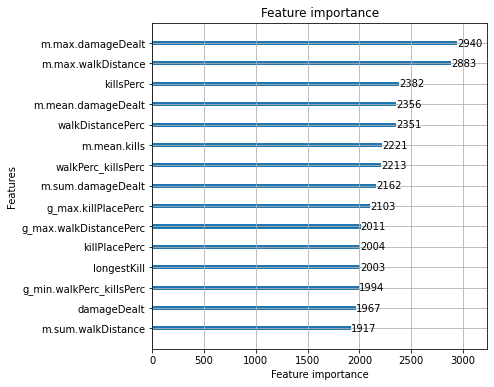

In [ ]:
f, ax = plt.subplots(figsize = (6,6))
plot_importance(model_lgb1, max_num_features = 15, ax = ax)

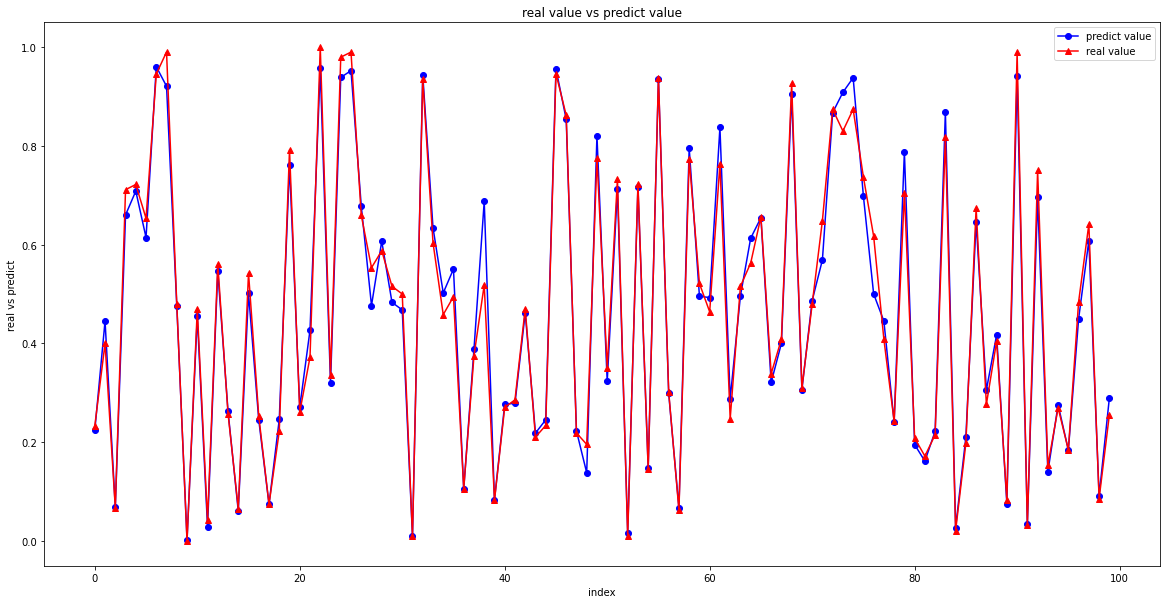

In [ ]:
fig = plt.figure( figsize = (20, 10) )
chart = fig.add_subplot(1,1,1)
chart.plot(pred[:100], marker='o', color='blue', label='predict value')
chart.plot(y_test1.values[:100], marker='^', color='red', label='real value')
chart.set_title('real value vs predict value')
plt.xlabel('index')
plt.ylabel('real vs predict')
plt.legend(loc = 'best') 

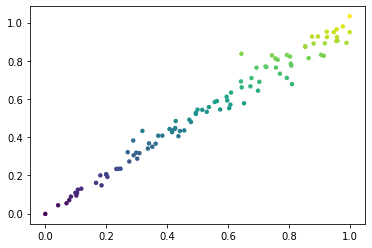

In [ ]:
plt.scatter(y_test1.values[:100],pred[:100], c=pred[:100], edgecolor = 'none', s =20)

In [ ]:
y_test1.values

array([0.7708, 0.9062, 0.7558, ..., 0.3579, 0.3229, 0.0851], dtype=float32)

# GradientBoost

기본 데이터셋

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train1, y_train1)
predictions = gbr.predict(X_test1)

In [ ]:
print("Gradient Boosting Regressor 기본 튜닝")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

Gradient Boosting Regressor 기본 튜닝
MSE : 0.002160
MAE : 0.032183
R2_Score : 0.974106
RMSE : 0.046479


gird cv

In [ ]:
params = {
    'alpha' : [0.3, 0.9],
    'n_estimators': [100, 200], 
    'learning_rate': [0.1, 0.05], 
    'max_depth': [3,7, 8], 
    'subsample': [0.8, 0.9],
}

In [ ]:
model_grb = GradientBoostingRegressor()
grb_search = GridSearchCV(model_grb, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grb_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [ ]:
print(grb_search.best_params_)

{'alpha': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}


In [ ]:
grb_best = grb_search.best_estimator_
grb_best.fit(X_train, y_train)


In [ ]:
predictions = grb_best.predict(X_test)

피팅

V2

In [ ]:
gbr2 = GradientBoostingRegressor(alpha = 0.9, learning_rate=0.1, max_depth = 7 ,n_estimators = 200 ,subsample = 0.9)
gbr2.fit(X_train2, y_train2)
pred = gbr2.predict(X_test2)

print("MSE : {:.6f}".format(mean_squared_error(pred, y_test2)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test2)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test2)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test2))))

MSE : 0.002707
MAE : 0.035794
R2_Score : 0.967858
RMSE : 0.052030


V4

In [ ]:
gbr4 = GradientBoostingRegressor(alpha = 0.9, learning_rate=0.1, max_depth = 7 ,n_estimators = 200 ,subsample = 0.9)
gbr4.fit(X_train4, y_train4)
pred = gbr4.predict(X_test4)

print("MSE : {:.6f}".format(mean_squared_error(pred, y_test4)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test4)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test4)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test4))))

MSE : 0.003062
MAE : 0.037413
R2_Score : 0.963023
RMSE : 0.055334


In [ ]:
컬럼V2_상관_gbr_mse = mean_squared_error(pred, y_test4)
컬럼V2_상관_gbr_mae = mean_absolute_error(pred, y_test4)
컬럼V2_상관_gbr_r2 = r2_score(pred, y_test4)
컬럼V2_상관_gbr_rmse = np.sqrt(mean_squared_error(pred, y_test4))

V1

In [ ]:
gbr1 = GradientBoostingRegressor(
    alpha = 0.9, 
    learning_rate=0.1, 
    max_depth = 7 ,
    n_estimators = 200 ,
    subsample = 0.9
    )

gbr1.fit(X_train1, y_train1)
pred = gbr1.predict(X_test1)

print("Gradient Boosting Regressor 튜닝 후")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

Gradient Boosting Regressor 기본 튜닝
MSE : 0.002160
MAE : 0.032183
R2_Score : 0.974106
RMSE : 0.046479


V3

In [ ]:
gbr3 = GradientBoostingRegressor(alpha = 0.9, learning_rate=0.1, max_depth = 7 ,n_estimators = 1000 ,subsample = 0.9)
gbr3.fit(X_train3, y_train3)
pred = gbr3.predict(X_test3)

print("MSE : {:.6f}".format(mean_squared_error(pred, y_test3)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test3)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test3)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test3))))

MSE : 0.002378
MAE : 0.034211
R2_Score : 0.971648
RMSE : 0.048763


## Extra Trees Regressor

In [ ]:
et_model=ExtraTreesRegressor()
et_model.fit(X_train1,y_train1)
pred = et_model.predict(X_test1)


print("Extra Trees Regressor 기본 튜닝")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

Extra Trees Regressor 기본 튜닝
MSE : 0.002882
MAE : 0.037902
R2_Score : 0.964846
RMSE : 0.053682


In [ ]:
params ={
    'n_estimators':[100,200 ,500],
    'max_depth':[6,8,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,20]
}

model_et = ExtraTreesRegressor( n_jobs = 5)
grid_cv = GridSearchCV(model_et, scoring='neg_mean_squared_error',param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
et_best = grid_cv.best_estimator_
et_best.fit(X_train, y_train)

predictions = et_best.predict(X_test)
print("MSE : {:.10f}".format(mean_squared_error(predictions, y_test)))
print("MAE :",mean_absolute_error(predictions, y_test))

{'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 200}
MSE : 0.0032441036
MAE : 0.039842761260366254


In [ ]:
params ={
    'n_estimators':200 ,
    'max_depth': 12,
    'min_samples_leaf':8,
    'min_samples_split':8
}


# 모델 객체 생성
et_model=ExtraTreesRegressor( n_estimators = 200 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )

V2

In [ ]:
et_model2=ExtraTreesRegressor( n_estimators = 200 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )



et_model2.fit(X_train2,y_train2)
pred = et_model2.predict(X_test2)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test2)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test2)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test2)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test2))))

MSE : 0.004208
MAE : 0.044422
R2_Score : 0.948576
RMSE : 0.064871


V4

In [ ]:
et_model4=ExtraTreesRegressor( n_estimators = 200 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )



et_model4.fit(X_train4,y_train4)
pred = et_model4.predict(X_test4)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test4)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test4)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test4)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test4))))

MSE : 0.004287
MAE : 0.044459
R2_Score : 0.946383
RMSE : 0.065473


V1

In [ ]:
et_model1=ExtraTreesRegressor( 
    n_estimators = 200 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )

et_model1.fit(X_train1,y_train1)
pred = et_model1.predict(X_test1)



print("Extra Trees Regressor 튜닝 후")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

Extra Trees Regressor 튜닝 후
MSE : 0.003276
MAE : 0.040375
R2_Score : 0.959586
RMSE : 0.057240


In [ ]:
컬럼V1_et_mse = mean_squared_error(pred, y_test1)
컬럼V1_et_mae = mean_absolute_error(pred, y_test1)
컬럼V1_et_r2 = r2_score(pred, y_test1)
컬럼V1_et_rmse = np.sqrt(mean_squared_error(pred, y_test1))

V3

In [ ]:
et_model3=ExtraTreesRegressor( n_estimators = 200 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 )


et_model3.fit(X_train3,y_train3)
pred = et_model3.predict(X_test3)
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test3)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test3)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test3)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test3))))

MSE : 0.003461
MAE : 0.040755
R2_Score : 0.957277
RMSE : 0.058831


In [ ]:
컬럼V1_상관_et_mse = mean_squared_error(pred, y_test3)
컬럼V1_상관_et_mae = mean_absolute_error(pred, y_test3)
컬럼V1_상관_et_r2 = r2_score(pred, y_test3)
컬럼V1_상관_et_rmse = np.sqrt(mean_squared_error(pred, y_test3))

# RandomForest


기본튜닝

In [ ]:
model_rf = RandomForestRegressor()

model_rf.fit(X_train1, y_train1)

pred = model_rf.predict(X_test1)



print("RandomForest 기본 튜닝")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

RandomForest 기본 튜닝
MSE : 0.003119
MAE : 0.039211
R2_Score : 0.962058
RMSE : 0.055850


grid_cv

In [ ]:
params ={
    'n_estimators':[100,200 ,500],
    'max_depth':[6,8,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,20]
}

model_rf = RandomForestRegressor( n_jobs = 5)
grid_cv = GridSearchCV(model_rf, scoring='neg_mean_squared_error',param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train1, y_train1)

print(grid_cv.best_params_)
rf_best = grid_cv.best_estimator_
rf_best.fit(X_train1, y_train1)

predictions = rf_best.predict(X_test1)
print("MSE : {:.10f}".format(mean_squared_error(predictions, y_test1)))
print("MAE :",mean_absolute_error(predictions, y_test1))

{'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 500}
MSE : 0.0031670440
MAE : 0.03941141618315328


In [ ]:
model_rf = RandomForestRegressor( 
    n_estimators = 500 ,
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split =8,
    n_jobs = 5 
    )

model_rf.fit(X_train1,y_train1)
pred = model_rf.predict(X_test1)

print("RandomForest 튜닝 후")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

MSE : 0.003225
MAE : 0.039849
R2_Score : 0.960583
RMSE : 0.056792


In [ ]:
print("RandomForest 튜닝 후")
print("MSE : {:.6f}".format(mean_squared_error(pred, y_test1)))
print("MAE : {:.6f}".format(mean_absolute_error(pred, y_test1)))
print("R2_Score : {:.6f}".format(r2_score(pred, y_test1)))
print("RMSE : {:.6f}".format(np.sqrt(mean_squared_error(pred, y_test1))))

RandomForest 튜닝 후
MSE : 0.003225
MAE : 0.039849
R2_Score : 0.960583
RMSE : 0.056792


# AutoML (PyCaret)

## > 모델 비교

In [ ]:
# 참고링크: http://www.pycaret.org/tutorials/html/REG102.html

In [ ]:
# PyCaret 패키지 설치
!pip install pycaret

In [ ]:
# 회귀분석에 필요한 pycaret 모듈 전부 불러오기
from pycaret.regression import *

In [ ]:
# 데이터 생성해주기 
data = all_data.copy()
data.drop(['matchId','groupId'], axis=1, inplace=True)

In [ ]:
# 우선 옵션을 추가하지 않고 객체생성
# session_id를 설정해두면 해당 모델에 randomstate 값에 적용된다.
exp = setup(data = data, target = 'winPlacePerc', session_id = 123) 

,Description,Value
0,session_id,123
1,Target,winPlacePerc
2,Original Data,"(15798, 82)"
3,Missing Values,False
4,Numeric Features,81
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(11058, 78)"


In [ ]:
# 모델 비교
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0353,2.500000e-03,0.0503,9.706000e-01,0.0319,0.1090,0.914
et,Extra Trees Regressor,0.0391,3.100000e-03,0.0559,9.637000e-01,0.0354,0.1167,11.218
rf,Random Forest Regressor,0.0395,3.200000e-03,0.0568,9.624000e-01,0.0359,0.1207,27.345
gbr,Gradient Boosting Regressor,0.0435,3.800000e-03,0.0613,9.563000e-01,0.0390,0.1403,8.612
br,Bayesian Ridge,0.0470,4.000000e-03,0.0628,9.541000e-01,0.0401,0.2006,0.099
ridge,Ridge Regression,0.0470,4.000000e-03,0.0629,9.539000e-01,0.0402,0.1994,0.036
lr,Linear Regression,0.0517,4.800000e-03,0.0683,9.446000e-01,0.0435,0.2331,0.366
omp,Orthogonal Matching Pursuit,0.0552,5.500000e-03,0.0740,9.363000e-01,0.0484,0.2393,0.037
dt,Decision Tree Regressor,0.0556,6.600000e-03,0.0811,9.235000e-01,0.0513,0.1630,0.481
ada,AdaBoost Regressor,0.0669,7.100000e-03,0.0843,9.174000e-01,0.0554,0.3450,3.669


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## > 모델 생성하기

### >> MSE 기준 상위 3개 모델 상세 

In [ ]:
# lightgbm 모델 생성 
# lightgbm을 5회 교차검증해본 것 소수점은 8자리까지 표시
lightgbm = create_model('lightgbm', fold = 5, round = 8)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.035806,0.002553,0.050527,0.970198,0.031957,0.116028
1,0.036185,0.002634,0.051319,0.969499,0.032309,0.110962
2,0.035934,0.002483,0.049830,0.970756,0.031656,0.109544
3,0.035317,0.002615,0.051139,0.969922,0.032393,0.115480
4,0.034632,0.002559,0.050587,0.970459,0.032283,0.098040
Mean,0.035575,0.002569,0.050680,0.970167,0.032120,0.110011
SD,0.000550,0.000053,0.000524,0.000434,0.000275,0.006489


In [ ]:
# et 모델 생성
# et를 5회 교차검증해본 것 소수점은 8자리까지 표시
et = create_model('et', fold = 5, round = 8)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.040258,0.003290,0.057363,0.961590,0.036430,0.127230
1,0.040171,0.003249,0.056998,0.962375,0.035921,0.120643
2,0.039525,0.003071,0.055421,0.963825,0.035269,0.119457
3,0.039733,0.003241,0.056928,0.962726,0.036021,0.121278
4,0.038727,0.003216,0.056711,0.962874,0.035742,0.105317
Mean,0.039683,0.003214,0.056684,0.962678,0.035877,0.118785
SD,0.000550,0.000075,0.000666,0.000726,0.000378,0.007250


In [ ]:
# rf 모델 생성 
# rf를 5회 교차검증해본 것 소수점은 8자리까지 표시
rf = create_model('rf', fold = 5, round = 8)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.040738,0.003408,0.058378,0.960218,0.036860,0.128413
1,0.040785,0.003375,0.058096,0.960912,0.036438,0.119452
2,0.039879,0.003126,0.055908,0.963186,0.035414,0.118672
3,0.040323,0.003504,0.059194,0.959700,0.037748,0.143425
4,0.038524,0.003217,0.056722,0.962859,0.035719,0.105333
Mean,0.040050,0.003326,0.057660,0.961375,0.036436,0.123059
SD,0.000830,0.000136,0.001184,0.001403,0.000832,0.012569


### >> 블랜딩 모델

In [ ]:
blend = blend_models(estimator_list = [lightgbm,et,rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0366,0.0027,0.0520,0.9693,0.0330,0.1171
1,0.0385,0.0029,0.0543,0.9645,0.0343,0.1217
2,0.0374,0.0028,0.0526,0.9673,0.0333,0.1133
3,0.0378,0.0030,0.0545,0.9663,0.0339,0.1086
4,0.0366,0.0026,0.0507,0.9695,0.0325,0.1122
5,0.0374,0.0028,0.0526,0.9675,0.0332,0.1102
6,0.0368,0.0029,0.0542,0.9655,0.0344,0.1242
7,0.0370,0.0028,0.0525,0.9688,0.0331,0.1155
8,0.0357,0.0025,0.0505,0.9700,0.0318,0.0993
9,0.0359,0.0030,0.0545,0.9664,0.0347,0.0999


 - lightgbm 단독 모델과 비교 

 - 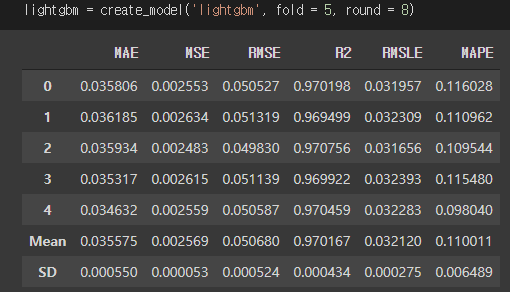

In [ ]:
# 열심히 블랜딩 했지만 기존 1위 였던 lightgbm이 성능이 더 우수함을 볼 수 있었다.
# setup에 저장된 데이터를 통해 예측을 수행 , 모델 성능 표시
pred_holdout = predict_model(blend)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0363,0.0027,0.0521,0.9683,0.0329,0.1055


In [ ]:
# 전체 데이터에 대해 재학습을 시행한다.
final_model = finalize_model(blend)

In [ ]:
# 파이널 모델을 통한 예측
predictions = predict_model(final_model, data = X_test)

In [ ]:
# test데이터의 값과 예측값(Label)이 데이터 프레임으로 만들어진다
predictions

,players,assists,damageDealt,killPlace,kills,longestKill,maxPlace,numGroups,revives,teamKills,walkDistance,weaponsAcquired,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,g_max.assists,g_max.damageDealt,g_max.killPlace,g_max.kills,g_max.longestKill,g_max.revives,g_max.teamKills,g_max.walkDistance,g_max.weaponsAcquired,g_max.killsPerc,g_max.killPlacePerc,g_max.walkDistancePerc,g_max.walkPerc_killsPerc,g_max._totalDistance,g_max._healthItems,g_max._headshotKillRate,g_max._killPlaceOverMaxPlace,g_max._killsOverWalkDistance,g_min.assists,...,g_min.kills,g_min.longestKill,g_min.revives,g_min.teamKills,g_min.walkDistance,g_min.weaponsAcquired,g_min.killsPerc,g_min.killPlacePerc,g_min.walkDistancePerc,g_min.walkPerc_killsPerc,g_min._totalDistance,g_min._healthItems,g_min._headshotKillRate,g_min._killPlaceOverMaxPlace,g_min._killsOverWalkDistance,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._healthItems,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._healthItems,g_sum.kills,g_sum.killPlace,g_sum.damageDealt,g_sum.walkDistance,g_sum._healthItems,duo,solo,squad,Label
15317,1,0.0,200.000000,16.0,2.0,152.500000,95.0,94.0,0.0,0.0,1834.000000,3.0,0.844086,0.172043,0.827957,0.980892,1834.000000,5.0,0.500000,0.168421,0.001091,0,200.000000,16,2,152.500000,0,0,1834.000000,3,0.844086,0.172043,0.827957,0.980892,1834.000000,5,0.500000,0.168421,0.001091,0,...,2,152.500000,0,0,1834.000000,3,0.844086,0.172043,0.827957,0.980892,1834.000000,5,0.5,0.168421,0.001091,93,92.0,4379.0,10667.990234,77847.250000,175.0,6,95,622.200012,3695.0,14,0.989247,47.086022,114.709572,837.067200,1.881720,2.0,16.0,200.000000,1834.000000,5.0,0,1,0,0.772741
12401,2,0.5,341.445007,28.5,3.0,25.180000,47.0,47.0,0.0,0.0,2298.000000,8.0,0.642473,0.306452,0.747312,1.426451,2532.550049,4.0,0.166667,0.606383,0.001003,1,624.299988,54,6,50.360001,0,0,2991.000000,9,0.978495,0.580645,0.903226,1.929825,3460.100098,5,0.333333,1.148936,0.002006,0,...,0,0.000000,0,0,1605.000000,7,0.306452,0.032258,0.591398,0.923077,1605.000000,3,0.0,0.063830,0.000000,93,89.0,4407.0,13244.270508,125421.148438,248.0,9,94,955.400024,4064.0,15,0.956989,47.387097,142.411499,1348.614502,2.666667,6.0,57.0,682.890015,4596.000000,8.0,1,0,0,0.664050
12904,1,0.0,0.000000,62.0,0.0,0.000000,98.0,97.0,0.0,0.0,810.400024,4.0,0.255102,0.632653,0.408163,1.600000,7738.399902,0.0,0.000000,0.632653,0.000000,0,0.000000,62,0,0.000000,0,0,810.400024,4,0.255102,0.632653,0.408163,1.600000,7738.399902,0,0.000000,0.632653,0.000000,0,...,0,0.000000,0,0,810.400024,4,0.255102,0.632653,0.408163,1.600000,7738.399902,0,0.0,0.632653,0.000000,98,89.0,4851.0,12030.259766,149949.703125,413.0,7,98,904.099976,9732.0,33,0.908163,49.500000,122.757751,1530.099121,4.214286,0.0,62.0,0.000000,810.400024,0.0,0,1,0,0.510321
8380,2,0.0,0.000000,81.5,0.0,0.000000,49.0,49.0,0.0,0.0,233.750000,2.0,0.301020,0.831633,0.214286,0.711864,233.750000,0.0,0.000000,1.663265,0.000000,0,0.000000,82,0,0.000000,0,0,271.100006,3,0.301020,0.836735,0.244898,0.813559,271.100006,0,0.000000,1.673469,0.000000,0,...,0,0.000000,0,0,196.399994,1,0.301020,0.826531,0.183673,0.610169,196.399994,0,0.0,1.653061,0.000000,98,92.0,4851.0,12065.839844,107413.171875,229.0,8,98,703.400024,3200.0,15,0.938776,49.500000,123.120819,1096.052856,2.336735,0.0,163.0,0.000000,467.500000,0.0,1,0,0,0.173239
11853,1,0.0,256.600006,13.0,2.0,190.800003,96.0,95.0,0.0,0.0,2173.000000,6.0,0.864583,0.135417,0.906250,1.048193,2173.000000,3.0,1.000000,0.135417,0.000920,0,256.600006,13,2,190.800003,0,0,2173.000000,6,0.864583,0.135417,0.906250,1.048193,2173.000000,3,1.000000,0.135417,0.000920,0,...,2,190.800003,0,0,2173.000000,6,0.864583,0.135417,0.906250,1.048193,2173.000000,3,1.0,0.135417,0.000920,96,91.0,4656.0,10849.179688,73343.773438,127.0,10,96,1013.000000,

In [ ]:
# 라벨값만 뽑아서 pred에 넣음
pred = predictions.Label

In [ ]:
print ("MSE: ", mean_squared_error(pred, y_test))

MSE:  0.0003684075487371079


In [ ]:
# 새로운 데이터에 대해서도 예측
predictions_new = predict_model(final_model, data =X_new)

In [ ]:
# 출력확인
predictions_new

,players,assists,damageDealt,killPlace,kills,longestKill,maxPlace,numGroups,revives,teamKills,walkDistance,weaponsAcquired,killsPerc,killPlacePerc,walkDistancePerc,walkPerc_killsPerc,_totalDistance,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,g_max.assists,g_max.damageDealt,g_max.killPlace,g_max.kills,g_max.longestKill,g_max.revives,g_max.teamKills,g_max.walkDistance,g_max.weaponsAcquired,g_max.killsPerc,g_max.killPlacePerc,g_max.walkDistancePerc,g_max.walkPerc_killsPerc,g_max._totalDistance,g_max._healthItems,g_max._headshotKillRate,g_max._killPlaceOverMaxPlace,g_max._killsOverWalkDistance,g_min.assists,...,g_min.kills,g_min.longestKill,g_min.revives,g_min.teamKills,g_min.walkDistance,g_min.weaponsAcquired,g_min.killsPerc,g_min.killPlacePerc,g_min.walkDistancePerc,g_min.walkPerc_killsPerc,g_min._totalDistance,g_min._healthItems,g_min._headshotKillRate,g_min._killPlaceOverMaxPlace,g_min._killsOverWalkDistance,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._healthItems,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._healthItems,g_sum.kills,g_sum.killPlace,g_sum.damageDealt,g_sum.walkDistance,g_sum._healthItems,duo,solo,squad,Label
0,1,0.0,0.000,85.0,0.0,0.000,97.0,95.0,0.0,0.0,27.9200,2.0,0.244792,0.885417,0.156250,0.638298,27.9200,0.0,0.000000,0.876289,0.000000,0,0.00,85,0,0.000,0,0,27.92,2,0.244792,0.885417,0.156250,0.638298,27.92,0,0.000000,0.876289,0.000000,0,...,0,0.000,0,0,27.920,2,0.244792,0.885417,0.156250,0.638298,27.920,0,0.000000,0.876289,0.000000,96,93.0,4661.0,11218.506,77485.64,149.0,5,97,517.2,3628.0,15,0.968750,48.552083,116.859436,807.14215,1.552083,0.0,85.0,0.00,27.920,0.0,0,1,0,0.130887
1,1,0.0,200.000,18.0,2.0,45.650,97.0,95.0,0.0,0.0,1520.0000,9.0,0.817708,0.187500,0.802083,0.980892,1520.0000,2.0,0.000000,0.185567,0.001316,0,200.00,18,2,45.650,0,0,1520.00,9,0.817708,0.187500,0.802083,0.980892,1520.00,2,0.000000,0.185567,0.001316,0,...,2,45.650,0,0,1520.000,9,0.817708,0.187500,0.802083,0.980892,1520.000,2,0.000000,0.185567,0.001316,96,93.0,4661.0,11218.506,77485.64,149.0,5,97,517.2,3628.0,15,0.968750,48.552083,116.859436,807.14215,1.552083,2.0,18.0,200.00,1520.000,2.0,0,1,0,0.748239
2,1,0.0,443.800,2.0,4.0,22.800,97.0,95.0,0.0,0.0,3440.0000,7.0,0.968750,0.020833,0.989583,1.021505,4397.8000,7.0,0.500000,0.020619,0.001163,0,443.80,2,4,22.800,0,0,3440.00,7,0.968750,0.020833,0.989583,1.021505,4397.80,7,0.500000,0.020619,0.001163,0,...,4,22.800,0,0,3440.000,7,0.968750,0.020833,0.989583,1.021505,4397.800,7,0.500000,0.020619,0.001163,96,93.0,4661.0,11218.506,77485.64,149.0,5,97,517.2,3628.0,15,0.968750,48.552083,116.859436,807.14215,1.552083,4.0,2.0,443.80,3440.000,7.0,0,1,0,0.975967
3,1,0.0,323.300,7.0,3.0,18.310,97.0,95.0,0.0,0.0,2673.0000,3.0,0.911458,0.072917,0.937500,1.028571,3654.9000,3.0,0.333333,0.072165,0.001122,0,323.30,7,3,18.310,0,0,2673.00,3,0.911458,0.072917,0.937500,1.028571,3654.90,3,0.333333,0.072165,0.001122,0,...,3,18.310,0,0,2673.000,3,0.911458,0.072917,0.937500,1.028571,3654.900,3,0.333333,0.072165,0.001122,96,93.0,4661.0,11218.506,77485.64,149.0,5,97,517.2,3628.0,15,0.968750,48.552083,116.859436,807.14215,1.552083,3.0,7.0,323.30,2673.000,3.0,0,1,0,0.939936
4,1,0.0,100.000,42.0,1.0,4.581,97.0,95.0,0.0,0.0,181.6000,3.0,0.619792,0.437500,0.385417,0.621849,181.6000,0.0,0.000000,0.432990,0.005507,0,100.00,42,1,4.581,0,0,181.60,3,0.619792,0.437500,0.385417,0.621849,181.60,0,0.000000,0.432990,0.005507,0,...,1,4.581,0,0,181.600,3,0.619792,0.437500,0.385417,0.621849,181.600,0,0.000000,0.432990,0.005507,96,93.0,4661.0,11218.506,77485.64,149.0,5,97,517.2,3628.0,15,0.968750,48.552083,116.859436,807.14215,1.552083,1.0,42.0,100.00,181.600,0.0,0,1,0,0.367743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
# 라벨값만 뽑아서 pred에 넣음
pred_new = predictions_new.Label

In [ ]:
print ("MSE - new: ", mean_squared_error(y_new, pred_new))

MSE - new:  0.002646435894408185
